# Purpose


2021-10-22:<br>
Test two things in this notebook:
- Test Agg clustering: how to train a model and roll it up to get consistent
- Test clustering metrics using primary-topic labels



Ad-hoc test clustering algos at **subreddit-level.**

Use experimentation in this notebook to inform the class/functions that will log & repeat the process in mlflow.

# Imports & Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [90]:
from datetime import datetime
import logging
from pathlib import Path

import numpy as np
import pandas as pd
import plotly
import plotly.express as px
import seaborn as sns

import mlflow
from tqdm import tqdm

import subclu
from subclu.eda.aggregates import compare_raw_v_weighted_language
from subclu.utils import set_working_directory, get_project_subfolder
from subclu.utils.eda import (
    setup_logging, counts_describe, value_counts_and_pcts,
    notebook_display_config, print_lib_versions,
    style_df_numeric, reorder_array,
)
from subclu.utils.mlflow_logger import MlflowLogger
from subclu.utils.hydra_config_loader import LoadHydraConfig
from subclu.utils.data_irl_style import (
    get_colormap, theme_dirl, 
    get_color_dict, base_colors_for_manual_labels,
    check_colors_used,
)
from subclu.data.data_loaders import LoadPosts, LoadSubreddits, create_sub_level_aggregates

from subclu.models import clustering, clustering_utils

# ===
# imports specific to this notebook
from collections import Counter
# import umap
# import openTSNE
# from openTSNE import TSNE

# import hdbscan

import sklearn
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize, Normalizer  # if we normalize the data, euclidean distance is approx of cosine
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, DBSCAN, OPTICS, AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph


print_lib_versions([np, pd, plotly, sklearn, sns, subclu])

python		v 3.7.10
===
numpy		v: 1.19.5
pandas		v: 1.2.4
plotly		v: 4.14.3
sklearn		v: 0.24.1
seaborn		v: 0.11.1
subclu		v: 0.4.0


In [3]:
# plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
plt.style.use('default')

setup_logging()
notebook_display_config()

# Set sqlite database as MLflow URI

In [4]:
# use new class to initialize mlflow
mlf = MlflowLogger(tracking_uri='sqlite')
mlflow.get_tracking_uri()

'sqlite:////home/jupyter/subreddit_clustering_i18n/mlflow_sync/djb-100-2021-04-28-djb-eda-german-subs/mlruns.db'

## Get list of experiments with new function

In [5]:
mlf.list_experiment_meta(output_format='pandas')

,experiment_id,name,artifact_location,lifecycle_stage
0,0,Default,./mlruns/0,active
1,1,fse_v1,gs://i18n-subreddit-clustering/mlflow/mlruns/1,active
2,2,fse_vectorize_v1,gs://i18n-subreddit-clustering/mlflow/mlruns/2,active
3,3,subreddit_description_v1,gs://i18n-subreddit-clustering/mlflow/mlruns/3,active
4,4,fse_vectorize_v1.1,gs://i18n-subreddit-clustering/mlflow/mlruns/4,active
5,5,use_multilingual_v0.1_test,gs://i18n-subreddit-clustering/mlflow/mlruns/5,active
6,6,use_multilingual_v1,gs://i18n-subreddit-clustering/mlflow/mlruns/6,active
7,7,use_multilingual_v1_aggregates_test,gs://i18n-subreddit-clustering/mlflow/mlruns/7,active
8,8,use_multilingual_v1_aggregates,gs://i18n-subreddit-clustering/mlflow/mlruns/8,active
9,9,v0.3.2_use_multi_inference_test,gs://i18n-subreddit-clustering/mlflow/mlruns/9,active


## Get experiment IDs to use for clustering

There are two runs that completed and they both have the same parameters, so we should be able to use either one. For now, let's select:<br>
`0591fdae9b7d4da7ae3839767b8aab66`

In [6]:
%%time

df_mlf = mlf.search_all_runs(experiment_ids=[16])
df_mlf.shape

CPU times: user 58 ms, sys: 5.95 ms, total: 63.9 ms
Wall time: 63.2 ms


(13, 86)

In [7]:
mask_finished = df_mlf['status'] == 'FINISHED'
mask_df_similarity_complete = ~df_mlf['metrics.df_sub_level_agg_a_post_only_similarity-rows'].isnull()

df_mlf_clustering_candidates = df_mlf[mask_finished & mask_df_similarity_complete]
df_mlf_clustering_candidates.shape

(2, 86)

In [8]:
cols_with_multiple_vals = df_mlf_clustering_candidates.columns[df_mlf_clustering_candidates.nunique(dropna=False) > 1]

df_mlf_clustering_candidates[cols_with_multiple_vals]

,run_id,artifact_uri,start_time,end_time,metrics.vectorizing_time_minutes,metrics.memory_used_percent,metrics.memory_used,metrics.memory_free,params.memory_used_percent,params.memory_used,params.memory_free,params.run_name,params.f_log_file,tags.mlflow.runName
0,cbb12818e82345dda96928bfdab8b16b,gs://i18n-subreddit-clustering/mlflow/mlruns/16/cbb12818e82345dda96928bfdab8b16b/artifacts,2021-10-12 10:46:05.235000+00:00,2021-10-12 16:41:33.492000+00:00,355.468028,0.181436,702999.0,3465918.0,0.07188136995649137,278514,3465918,agg_full_lc_false_pd-2021-10-12_104604,logs/AggregateEmbeddings/2021-10-12_10-46-05_agg_full_lc_false_pd-2021-10-12_104604.log,agg_full_lc_false_pd-2021-10-12_104604
1,0591fdae9b7d4da7ae3839767b8aab66,gs://i18n-subreddit-clustering/mlflow/mlruns/16/0591fdae9b7d4da7ae3839767b8aab66/artifacts,2021-10-12 10:27:33.324000+00:00,2021-10-12 16:40:41.501000+00:00,373.134208,0.181490,703208.0,3681161.0,0.016713578624458464,64759,3681161,agg_full_lc_false-2021-10-12_102732,logs/AggregateEmbeddings/2021-10-12_10-27-33_agg_full_lc_false-2021-10-12_102732.log,agg_full_lc_false-2021-10-12_102732


# Set path for saving intermediary files

In [9]:
path_this_model = get_project_subfolder(
    f"data/models/clustering/manual_v040_{datetime.utcnow().strftime('%Y-%m-%d_%H_%M')}"
)
Path.mkdir(path_this_model, parents=True, exist_ok=True)
path_this_model

PosixPath('/home/jupyter/subreddit_clustering_i18n/data/models/clustering/manual_v040_2021-10-25_15_55')

In [10]:
path_nb_this_model = Path(f"djb_clustering_ignore/manual_v040_{datetime.utcnow().strftime('%Y-%m-%d_%H_%M')}")
Path.mkdir(path_nb_this_model, parents=True, exist_ok=True)
path_nb_this_model

PosixPath('djb_clustering_ignore/manual_v040_2021-10-25_15_55')

In [11]:
# path_this_model_prev_run = Path(
#     '/home/jupyter/subreddit_clustering_i18n/data/models/clustering/manual_2021-07-20_15_13'
# )
# path_this_model_prev_run

# Load & inspect config for clustering job

This config should include:
- data to load for clustering
- parameters for clustering algo
- hydra overrides to run jobs in parallel

In [12]:
test_experiment = 'v0.4.0_use_multi_clustering_test'

cfg_cluster_test_v040 = LoadHydraConfig(
    config_name='clustering_v0.4.0_base',
    config_path="../config",
    overrides=[
        f"mlflow_experiment_name={test_experiment}"
#         f"data_text_and_metadata=top_subreddits_2021_07_16",
#         f"data_embeddings_to_cluster=top_subs-2021_07_16-use_multi_lower_case_false_00",
    ],
)

print([k for k in cfg_cluster_test_v040.config_dict.keys()])

['data_text_and_metadata', 'data_embeddings_to_cluster', 'clustering_algo', 'embeddings_to_cluster', 'mlflow_tracking_uri', 'mlflow_experiment_name', 'pipeline']


In [13]:
# data with embeddings
cfg_cluster_test_v040.config_dict['data_embeddings_to_cluster']

{'run_uuid': '0591fdae9b7d4da7ae3839767b8aab66',
 'l_ix_sub': ['subreddit_name', 'subreddit_id'],
 'l_ix_post': ['subreddit_name', 'post_id'],
 'df_post_level_agg_b_post_and_comments': None,
 'df_post_level_agg_c_post_comments_sub_desc': 'df_post_level_agg_c_post_comments_sub_desc',
 'df_sub_level_agg_a_post_only': 'df_sub_level_agg_a_post_only',
 'df_sub_level_agg_a_post_only_similarity': 'df_sub_level_agg_a_post_only_similarity',
 'df_sub_level_agg_a_post_only_similarity_pair': 'df_sub_level_agg_a_post_only_similarity_pair',
 'df_sub_level_agg_a_post_only_similarity_top_pair': 'df_sub_level_agg_a_post_only_similarity_top_pair',
 'df_sub_level_agg_b_post_and_comments': None,
 'df_sub_level_agg_b_post_and_comments_similarity': None,
 'df_sub_level_agg_b_post_and_comments_similarity_pair': None,
 'df_sub_level_agg_c_post_comments_and_sub_desc': 'df_sub_level_agg_c_post_comments_and_sub_desc',
 'df_sub_level_agg_c_post_comments_and_sub_desc_similarity': 'df_sub_level_agg_c_post_comments_

In [14]:
# clustering algo
cfg_cluster_test_v040.config_dict['clustering_algo']

{'model_name': 'AgglomerativeClustering',
 'model_kwargs': {'n_clusters': 100,
  'affinity': 'euclidean',
  'linkage': 'ward',
  'connectivity': False}}

In [15]:
run_uuid = cfg_cluster_test_v040.config_dict['data_embeddings_to_cluster']['run_uuid']

# Load vectors for selected run

In [16]:
# %%time

# df_logs = mlf.read_run_artifact(
#     run_id=run_uuid,
#     artifact_file='2021-10-12_10-27-33_agg_full_lc_false-2021-10-12_102732.log',
#     read_function='pd_csv',
#     verbose=False,
#     read_csv_kwargs=dict(sep='|', quotechar='"', error_bad_lines=False)
# )
# df_logs.shape

In [17]:
# df_logs.head()

In [18]:
# %%time

# mlf.list_run_artifacts(
#     run_id=cfg_cluster_test_v040.config_dict['data_embeddings_to_cluster']['run_uuid'],
#     verbose=False,
#     only_top_level=True,
# )

In [19]:
%%time
d_dfs_mlflow = mlf.read_run_artifact(
    run_id=cfg_cluster_test_v040.config_dict['data_embeddings_to_cluster']['run_uuid'],
    artifact_file='d_logged_dfs_subfolders/d_logged_dfs_subfolders.json',
    read_function='json',
    verbose=False,
)

15:55:41 | INFO | "Local folder to download artifact(s):
  /home/jupyter/subreddit_clustering_i18n/data/local_cache/mlflow/mlruns/16/0591fdae9b7d4da7ae3839767b8aab66/artifacts/d_logged_dfs_subfolders"
100%|###########################################| 2/2 [00:00<00:00, 8756.38it/s]

CPU times: user 712 ms, sys: 25.1 ms, total: 737 ms
Wall time: 882 ms


In [20]:
list(d_dfs_mlflow.keys())

['df_sub_level_agg_c_post_comments_and_sub_desc',
 'df_sub_level_agg_c_post_comments_and_sub_desc_similarity',
 'df_sub_level_agg_c_post_comments_and_sub_desc_similarity_pair',
 'df_sub_level_agg_c_post_comments_and_sub_desc_similarity_top_pair',
 'df_sub_level_agg_a_post_only',
 'df_sub_level_agg_a_post_only_similarity',
 'df_sub_level_agg_a_post_only_similarity_pair',
 'df_sub_level_agg_a_post_only_similarity_top_pair',
 'df_post_level_agg_c_post_comments_sub_desc']

In [21]:
f_embeddings_sub_level = 'df_sub_level_agg_c_post_comments_and_sub_desc'
f_embeddings_post_level = 'df_post_level_agg_c_post_comments_sub_desc'

f_sub_distance_c = 'df_sub_level_agg_c_post_comments_and_sub_desc_similarity'

f_sub_distance_c_pair = 'df_sub_level_agg_c_post_comments_and_sub_desc_similarity_pair'
f_sub_distance_c_pair_top = 'df_sub_level_agg_c_post_comments_and_sub_desc_similarity_top_pair'

## Subreddit-level embeddings


In [22]:
%%time

df_v_sub = mlf.read_run_artifact(
    run_id=run_uuid,
    artifact_folder=f_embeddings_sub_level,
    read_function='pd_parquet',
    verbose=False,
).drop(['index'], axis=1)

print(df_v_sub.shape)

15:55:43 | INFO | "Local folder to download artifact(s):
  /home/jupyter/subreddit_clustering_i18n/data/local_cache/mlflow/mlruns/16/0591fdae9b7d4da7ae3839767b8aab66/artifacts/df_sub_level_agg_c_post_comments_and_sub_desc"
100%|##################################| 2176/2176 [00:00<00:00, 1012851.57it/s]
15:55:43 | INFO | "  Parquet files found:     3"
15:55:43 | INFO | "  Parquet files to use:     3"


(19192, 514)
CPU times: user 1.05 s, sys: 568 ms, total: 1.62 s
Wall time: 1.37 s


In [23]:
%%time
df_v_sub.iloc[:10, :18]

CPU times: user 387 µs, sys: 283 µs, total: 670 µs
Wall time: 653 µs


,subreddit_name,subreddit_id,embeddings_0,embeddings_1,embeddings_2,embeddings_3,embeddings_4,embeddings_5,embeddings_6,embeddings_7,embeddings_8,embeddings_9,embeddings_10,embeddings_11,embeddings_12,embeddings_13,embeddings_14,embeddings_15
0,0sanitymemes,t5_2qlzfy,-0.015309,-0.000338,0.004237,-0.003082,-0.005160,0.039126,-0.007306,-0.001087,-0.040298,0.005632,0.014986,0.008301,0.009121,-0.001766,0.002140,0.004529
1,0xpolygon,t5_2qgijx,-0.032465,0.040708,-0.038430,-0.053849,-0.011010,0.011037,0.002698,0.001709,-0.006547,0.016146,0.026604,0.011281,0.032107,0.006964,-0.017149,0.030576
2,1000lbsisters,t5_2axvbl,-0.015282,-0.010422,0.003329,0.007292,0.000404,0.053924,0.018400,0.021107,-0.049664,0.021106,0.002576,0.033415,0.027110,-0.021416,0.001191,-0.011647
3,100gecs,t5_131dor,-0.004657,-0.008885,0.018894,0.004370,-0.031983,0.041073,0.014725,-0.007694,-0.048880,0.015949,-0.004769,0.001468,0.010662,-0.012723,0.011491,0.014758
4,100kanojo,t5_2asd3o,0.004579,0.022865,0.017590,-0.025580,0.004692,0.040058,0.003381,0.010890,-0.033801,0.039107,0.001168,0.034285,-0.017844,0.029286,-0.017823,-0.002958
5,100thieves,t5_3e98s,0.000797,-0.006705,0.013810,0.002443,0.006766,0.039071,0.005408,-0.008182,-0.034920,-0.006254,0.009869,-0.000474,0.010354,0.003454,0.004920,-0.001382
6,100yearsago,t5_2y3jq,0.002633,-0.006108,0.014209,-0.005926,0.030038,0.031586,-0.011541,-0.027743,0.054863,-0.005560,0.010610,-0.007959,-0.001142,0.002105,-0.032363,-0.009333
7,1022,t5_2v7cn,-0.024393,0.010842,0.001057,0.012960,-0.045104,0.046439,0.025671,0.000203,-0.049951,-0.005975,0.000300,0.008399,0.018779,0.004230,0.015567,0.012057
8,1050ti,t5_3aw8hb,-0.034112,0.022275,-0.005730,0.009530,-0.061777,-0.079557,0.004721,-0.037082,-0.012889,0.044403,0.059290,-0.042273,-0.021837,0.006665,0.036723,0.002950
9,10s,t5_2u7it,-0.015521,0.013037,0.003630,-0.013879,-0.043684,0.048049,0.013089,0.006329,-0.050186,0.013844,0.008129,-0.010067,0.049038,-0.014054,0.006099,0.007681


In [24]:
l_ix_sub = ['subreddit_name', 'subreddit_id',]
l_ix_post = ['subreddit_name', 'subreddit_id', 'post_id']
l_cols_embeddings = [c for c in df_v_sub.columns if c.startswith('embeddings_')]
print(len(l_cols_embeddings))

512


# Load metadata

Use it to get labels for metrics.

In [25]:
%%time

d_config_text_and_meta = cfg_cluster_test_v040.config_dict['data_text_and_metadata']

df_subs = LoadSubreddits(
    bucket_name=d_config_text_and_meta['bucket_name'],
    folder_path=d_config_text_and_meta['folder_subreddits_text_and_meta'],
    folder_posts=d_config_text_and_meta['folder_posts_text_and_meta'],
    columns=None,
).read_apply_transformations_and_merge_post_aggs(
    # cols_post='post_count_only_',  # use default so that we can calculate primary language
    df_format='pandas',
    read_fxn='dask',
    unique_check=False,
)

15:55:44 | INFO | "Loading df_posts from: posts/top/2021-09-27"
15:55:44 | INFO | "Reading raw data..."
15:55:44 | INFO | "  Local folder to download artifact(s):
  /home/jupyter/subreddit_clustering_i18n/data/local_cache/posts/top/2021-09-27"
100%|##############################| 27/27 [00:00<00:00, 43207.25it/s]
15:55:49 | INFO | "  Applying transformations..."
15:56:25 | INFO | "  reading sub-level data & merging with aggregates..."
15:56:25 | INFO | "Reading raw data..."
15:56:25 | INFO | "  Local folder to download artifact(s):
  /home/jupyter/subreddit_clustering_i18n/data/local_cache/subreddits/top/2021-09-24"
100%|#################################| 1/1 [00:00<00:00, 4332.96it/s]
15:56:26 | INFO | "  Applying transformations..."


CPU times: user 52.9 s, sys: 8.51 s, total: 1min 1s
Wall time: 58.2 s


In [224]:
df_subs.head()

,pt_date,subreddit_name,subreddit_id,geo_relevant_country_codes,geo_relevant_countries,geo_relevant_country_count,geo_relevant_subreddit,ambassador_subreddit,combined_topic,combined_topic_and_rating,rating_short,rating_name,primary_topic,secondary_topics,mature_themes_list,over_18,allow_top,video_whitelisted,subreddit_language,whitelist_status,subscribers,first_screenview_date,last_screenview_date,users_l7,users_l28,posts_l7,posts_l28,comments_l7,comments_l28,pt,...,Spanish_posts_percent,Swahili_posts_percent,Swedish_posts_percent,Tagalog_posts_percent,Thai_posts_percent,Turkish_posts_percent,UNKNOWN_posts_percent,Vietnamese_posts_percent,Welsh_posts_percent,primary_post_language,primary_post_language_percent,primary_post_language_in_use_multilingual,secondary_post_language,secondary_post_language_percent,crosspost_post_type_percent,gallery_post_type_percent,gif_post_type_percent,image_post_type_percent,link_post_type_percent,liveaudio_post_type_percent,multi_media_post_type_percent,poll_post_type_percent,rpan_post_type_percent,text_post_type_percent,video_post_type_percent,primary_post_type,primary_post_type_percent,posts_for_modeling_count,post_median_word_count,post_median_text_len
0,2021-09-21,askreddit,t5_2qh1i,None,None,NaN,False,False,uncategorized,uncategorized,E,Everyone,Learning and Education,,"profanity_occasional, profanity",f,t,None,es,all_ads,33604689,2020-08-24,2021-09-21,12563532,31513185,71934,296017,1525489,6194629,2021-09-24,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,English,0.997500,True,NaN,NaN,0.000000,0.0,0.0000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.000000,0.00,text,1.000000,1200.0,11.0,58.0
1,2021-09-21,pics,t5_2qh0u,None,None,NaN,False,False,art,art,E,Everyone,Art,,,f,t,None,en,all_ads,28014622,2020-08-24,2021-09-21,6062041,12928114,6101,24428,163585,742511,2021-09-24,...,0.001667,0.000833,0.000000,0.005000,0.0,0.001667,0.000000,0.000000,0.001667,English,0.935000,True,NaN,NaN,0.003333,0.0,0.0000,0.915000,0.081667,0.0,0.0,0.0,0.0,0.000000,0.00,image,0.915000,1200.0,10.0,57.0
2,2021-09-21,funny,t5_2qh33,None,None,NaN,False,False,uncategorized,uncategorized,E,Everyone,None,,,f,t,f,en,all_ads,37367466,2020-08-24,2021-09-21,5767977,12250775,6892,28839,114801,463485,2021-09-24,...,0.001667,0.000000,0.002500,0.010833,0.0,0.000000,0.000833,0.000833,0.007500,English,0.861667,True,German,0.015833,0.000000,0.0,0.0225,0.625000,0.071667,0.0,0.0,0.0,0.0,0.000833,0.28,image,0.625000,1200.0,6.0,33.0
3,2021-09-21,memes,t5_2qjpg,None,None,NaN,False,False,uncategorized,uncategorized,E,Everyone,Funny/Humor,,"profanity, profanity_occasional",f,t,f,en,all_ads,16335892,2020-08-24,2021-09-21,3969463,10101856,27518,118705,430622,1900286,2021-09-24,...,0.002500,0.003333,0.008333,0.009167,0.0,0.000000,0.000000,0.002500,0.006667,English,0.805833,True,Danish,0.015000,0.000000,0.0,0.0850,0.892500,0.022500,0.0,0.0,0.0,0.0,0.000000,0.00,image,0.892500,1200.0,4.0,23.0
4,2021-09-21,interestingasfuck,t5_2qhsa,None,None,NaN,False,False,uncategorized,uncategorized,E,Everyone,None,,"profanity, profanity_sr_name",f,t,f,en,all_ads,8638369,2020-08-24,2021-09-21,5197231,10071629,1955,7784,132845,522494,2021-09-24,...,0.001667,0.000000,0.001667,0.003333,0.0,0.000000,0.000000,0.000000,0.002500,English,0.937500,True,NaN,NaN,0.000000,0.0,0.0000,0.688333,0.311667,0.0,0.0,0.0,0.0,0.000000,0.00,image,0.688333,1200.0,11.0,60.0


### Check primary topic

In [26]:
df_subs['primary_topic'].nunique()

51

In [27]:
value_counts_and_pcts(
    df_subs['primary_topic'],
    top_n=52,
)

,primary_topic-count,primary_topic-percent,primary_topic-pct_cumulative_sum
nan,"3,262",16.9%,16.9%
Gaming,"2,478",12.9%,29.8%
Technology,"1,059",5.5%,35.3%
Internet Culture and Memes,823,4.3%,39.6%
Place,796,4.1%,43.7%
Music,681,3.5%,47.2%
Funny/Humor,656,3.4%,50.6%
Television,543,2.8%,53.5%
Sports,542,2.8%,56.3%
Mature Themes and Adult Content,534,2.8%,59.0%


# Run models

## Hierarchical clustering

Do it for subreddit-level only for now.

Set the number higher than the number of primary-topics in the raw data because I'd expect the embeddings to identify:
- sub-clusters and to
- embeddings clusters won't align with the labels in our taxonomy.

---

Linkage algos to try:
- Ward
    - euclidean (default)
    - cosine = (normalize vectors before applying euclidean distance)
- Average linkange
- Complete
- Single (ignore for now, it's brittle)

### Ward + cosine

- Get dendogram
    - [dendogram example](https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py)


### No connectivity

In [28]:
%%time

cls_agg_ward_cosine_coF = AgglomerativeClustering(
    n_clusters=65,
    compute_distances=True,
    compute_full_tree=True,
    affinity='euclidean',
    linkage='ward',
    connectivity=None,
)

cls_agg_ward_cosine_coF.fit(normalize(df_v_sub[l_cols_embeddings], norm='l2'))

CPU times: user 1min 34s, sys: 661 ms, total: 1min 35s
Wall time: 1min 34s


AgglomerativeClustering(compute_distances=True, compute_full_tree=True,
                        n_clusters=65)

In [29]:
%%time

print(f"Label count: {len(set(cls_agg_ward_cosine_coF.labels_)):,.0f}")

(
    pd.DataFrame([Counter(cls_agg_ward_cosine_coF.labels_)], index=['subreddit_count'])
    .T
    .rename_axis(index='cluster_id')
    .sort_values(by=['subreddit_count'], ascending=False)
    .head(9)
)

Label count: 65
CPU times: user 10.1 ms, sys: 3.45 ms, total: 13.5 ms
Wall time: 13 ms


,subreddit_count
cluster_id,
48,696
9,678
2,545
26,542
5,539
7,475
22,461
43,458
21,453


### Train with `connectivity`=knn-neighbors graph

In [30]:
%%time

knn_graph = kneighbors_graph(df_v_sub[l_cols_embeddings], 30, include_self=False, metric='cosine')

CPU times: user 45.3 s, sys: 1min 55s, total: 2min 40s
Wall time: 7.16 s


In [31]:
%%time

cls_agg_ward_cosine_coT = AgglomerativeClustering(
    n_clusters=65,
    compute_distances=True,
    compute_full_tree=True,
    affinity='euclidean',
    linkage='ward',
    connectivity=knn_graph,
)

cls_agg_ward_cosine_coT.fit(normalize(df_v_sub[l_cols_embeddings], norm='l2'))
print(len(set(cls_agg_ward_cosine_coT.labels_)))


65
CPU times: user 12.4 s, sys: 230 ms, total: 12.6 s
Wall time: 12.6 s


In [32]:
(
    pd.DataFrame([Counter(cls_agg_ward_cosine_coT.labels_)], index=['subreddit_count'])
    .T
    .rename_axis(index='cluster_id')
    .sort_values(by=['subreddit_count'], ascending=False)
)

,subreddit_count
cluster_id,
4,624
34,617
63,561
2,552
7,540
...,...
61,103
59,96
46,92


# Get linkage matrix

Use this matrix to:
- create dendrograms
- help find distance cutoffs to identify "optimal" threshold for clusters

In [33]:
%%time

X_linkage_coF = clustering_utils.create_linkage_for_dendrogram(cls_agg_ward_cosine_coF)
X_linkage_coF.shape

CPU times: user 47.9 ms, sys: 0 ns, total: 47.9 ms
Wall time: 47.2 ms


(19191, 4)

In [34]:
%%time

X_linkage_coT = clustering_utils.create_linkage_for_dendrogram(cls_agg_ward_cosine_coT)
X_linkage_coT.shape

CPU times: user 45.4 ms, sys: 813 µs, total: 46.2 ms
Wall time: 45.4 ms


(19191, 4)

At the lowest level, the distances are the same or nearly the same

In [35]:
pd.concat(
    [
        X_linkage_coF.head(), 
        X_linkage_coT.head()
    ],
    axis=1
)

,children_0,children_1,distance,count,children_0,children_1,distance,count
0,11072,11073,0.129154,2,11072,11073,0.129154,2
1,5578,5579,0.129204,2,5578,5579,0.129204,2
2,1125,12431,0.135377,2,1125,12431,0.135377,2
3,4151,4152,0.139023,2,4151,4152,0.139023,2
4,4144,4145,0.142191,2,4144,4145,0.142191,2


But once we get to the highest levels, the distances/clusters are different

In [36]:
pd.concat(
    [
        X_linkage_coF.tail(), 
        X_linkage_coT.tail()
    ],
    axis=1
)

,children_0,children_1,distance,count,children_0,children_1,distance,count
19186,38376,38377,20.251257,7979,38374,38375,20.287381,6973
19187,38375,38378,22.737677,10297,38363,38377,22.914772,6909
19188,38372,38374,23.546442,6410,38376,38378,24.402606,9471
19189,38360,38379,30.145653,12782,38364,38380,29.563897,12283
19190,38380,38381,36.800951,19192,38379,38381,36.493060,19192


In [38]:
counts_describe(X_linkage_coF)

,dtype,count,unique,unique-percent,null-count,null-percent
children_0,int64,"19,191","19,191",100.00%,0,0.00%
children_1,int64,"19,191","19,191",100.00%,0,0.00%
distance,float64,"19,191","19,191",100.00%,0,0.00%
count,int64,"19,191",309,1.61%,0,0.00%


In [39]:
counts_describe(X_linkage_coT)

,dtype,count,unique,unique-percent,null-count,null-percent
children_0,int64,"19,191","19,191",100.00%,0,0.00%
children_1,int64,"19,191","19,191",100.00%,0,0.00%
distance,float64,"19,191","19,191",100.00%,0,0.00%
count,int64,"19,191",312,1.63%,0,0.00%


In [40]:
style_df_numeric(
    pd.DataFrame(
        {
            'count_coF': X_linkage_coF['count'].describe(percentiles=[.25, .5, .75, 0.90, 0.95, .98, .985, .99, .995]),
            'count_coT': X_linkage_coT['count'].describe(percentiles=[.25, .5, .75, 0.90, 0.95, .98, .985, .99, .995]),

            'distance_coF': X_linkage_coF['distance'].describe(percentiles=[.25, .5, .75, 0.90, 0.95, .98, .985, .99, .995]),
            'distance_coT': X_linkage_coT['distance'].describe(percentiles=[.25, .5, .75, 0.90, 0.95, .98, .985, .99, .995]),
        },
    ).T,
    float_round=3,
)

,count,mean,std,min,25%,50%,75%,90%,95%,98%,98.5%,99%,99.5%,max
count_coF,"19,191",16.192,215.456,2.000,2.000,3.000,7.000,17.000,33.000,79.200,107.150,161.000,316.100,"19,192.000"
count_coT,"19,191",16.261,212.946,2.000,2.000,3.000,7.000,17.000,33.000,79.000,106.000,165.000,318.000,"19,192.000"
distance_coF,"19,191",0.816,0.847,0.129,0.515,0.664,0.881,1.236,1.630,2.483,2.853,3.545,5.003,36.801
distance_coT,"19,191",0.816,0.847,0.129,0.515,0.664,0.883,1.228,1.628,2.488,2.822,3.543,4.896,36.493


# Plot dendrograms & identify best cutoff

### `level` - Max levels deep to show
> 'level'
> No more than p levels of the dendrogram tree are displayed. A “level” includes all nodes with p merges from the final merge.

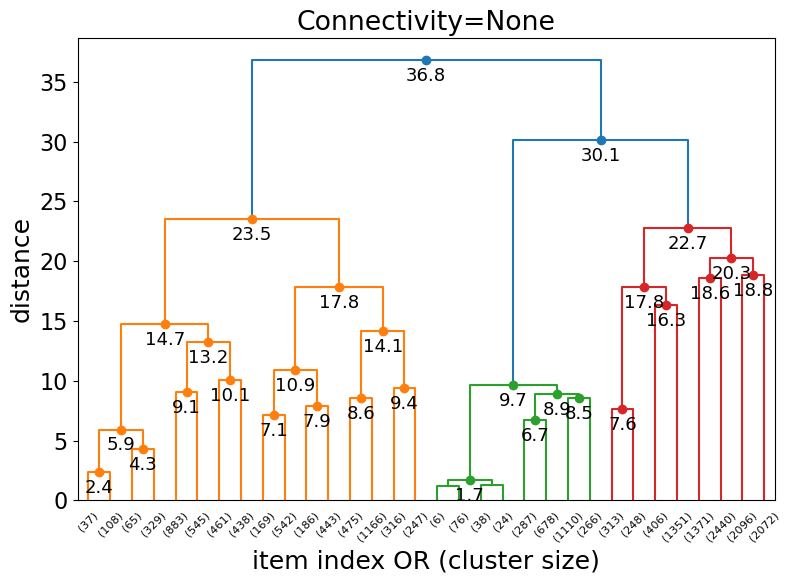

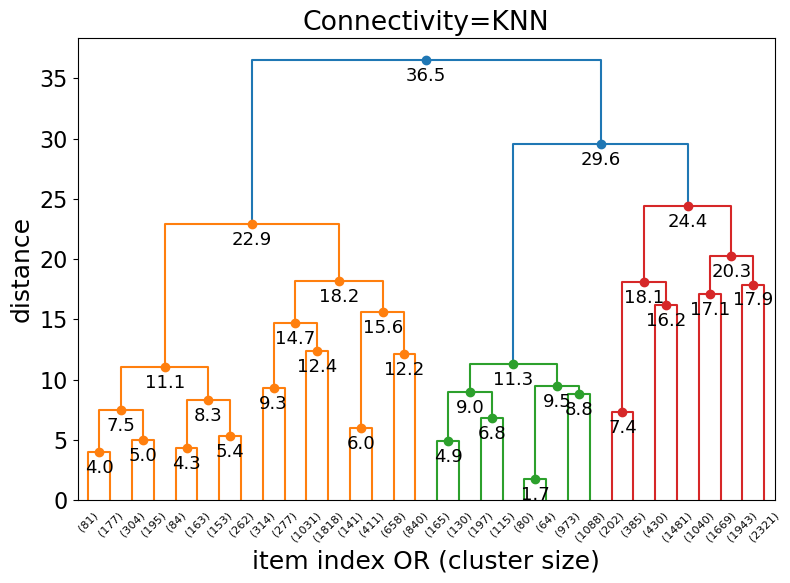

CPU times: user 1.13 s, sys: 25.4 ms, total: 1.16 s
Wall time: 1.15 s


In [41]:
%%time

# Level=4 <- Show 
R = clustering_utils.fancy_dendrogram(
    X_linkage_coF,
    annotate_above=X_linkage_coF['distance'].quantile(q=0.95),
    plot_title='Connectivity=None',
    truncate_mode='level',
    p=4,
    orientation='top'
)
plt.show()

R2 = clustering_utils.fancy_dendrogram(
    X_linkage_coT,
    annotate_above=X_linkage_coT['distance'].quantile(q=0.95),
    plot_title='Connectivity=KNN',
    truncate_mode='level',
    p=4,
    orientation='top'
)
plt.show()

### `lastp` <- Number of clusters
> The last p non-singleton clusters formed in the linkage are the only non-leaf nodes in the linkage; they correspond to rows Z[n-p-2:end] in Z. All other non-singleton clusters are contracted into leaf nodes.

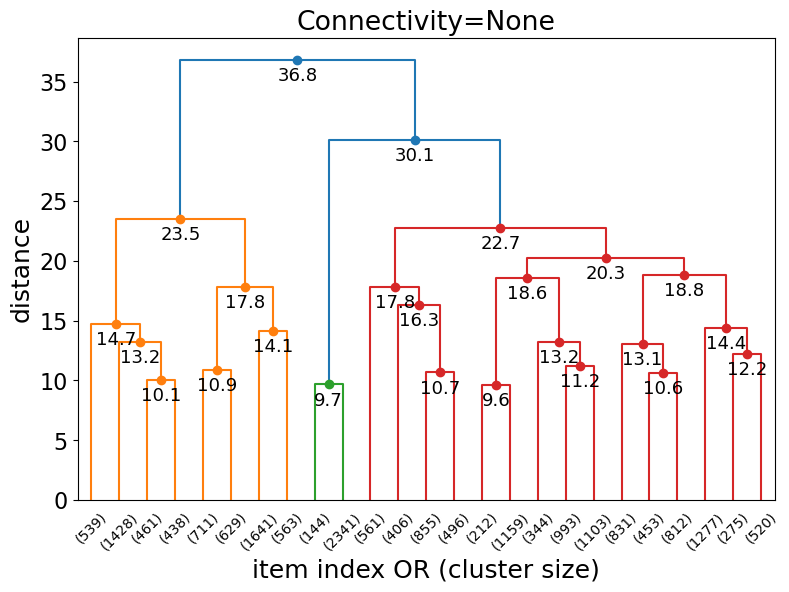

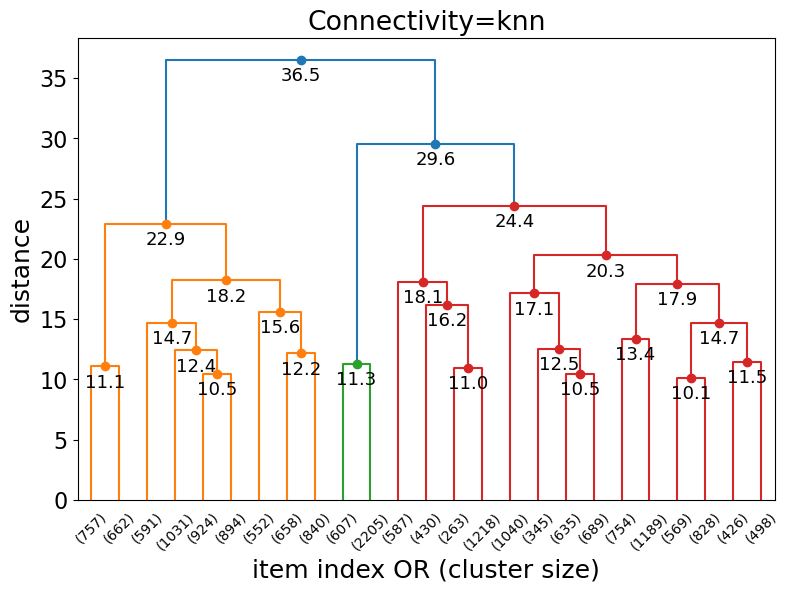

CPU times: user 960 ms, sys: 33 ms, total: 993 ms
Wall time: 990 ms


In [42]:
%%time

# lastp =25 <- show 25 clusters
clustering_utils.fancy_dendrogram(
    X_linkage_coF,
    plot_title='Connectivity=None',
    truncate_mode='lastp',
    p=25,
    orientation='top',
    show_leaf_counts=True, leaf_rotation=45,
    show_contracted=False,
)
plt.show()

clustering_utils.fancy_dendrogram(
    X_linkage_coT,
    plot_title='Connectivity=knn',
    truncate_mode='lastp',
    p=25,
    orientation='top',
    show_leaf_counts=True, leaf_rotation=45,
    show_contracted=False,
)
plt.show()

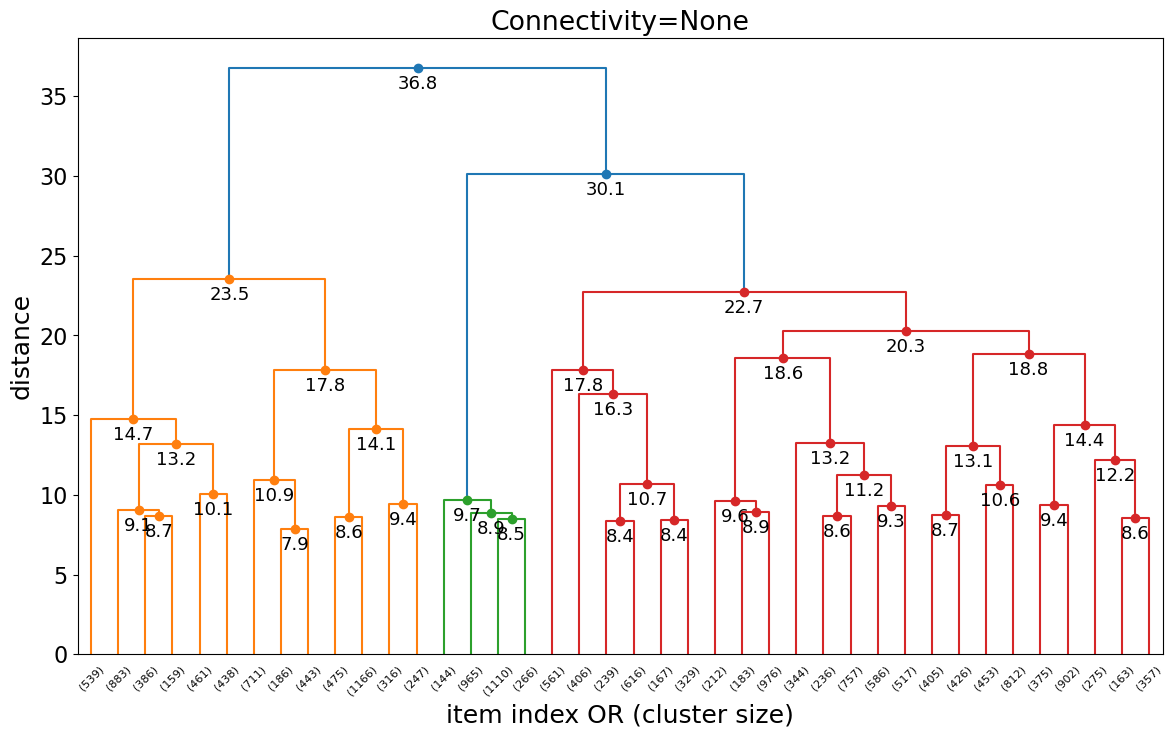

In [43]:
fig = plt.figure(figsize=(14, 8))

clustering_utils.fancy_dendrogram(
    X_linkage_coF,
    plot_title='Connectivity=None',
    annotate_above=X_linkage_coF['distance'].quantile(q=0.99),
    truncate_mode='lastp',
    p=40,
    orientation='top',
    show_leaf_counts=True, leaf_rotation=45,
    show_contracted=False,
)
plt.show()

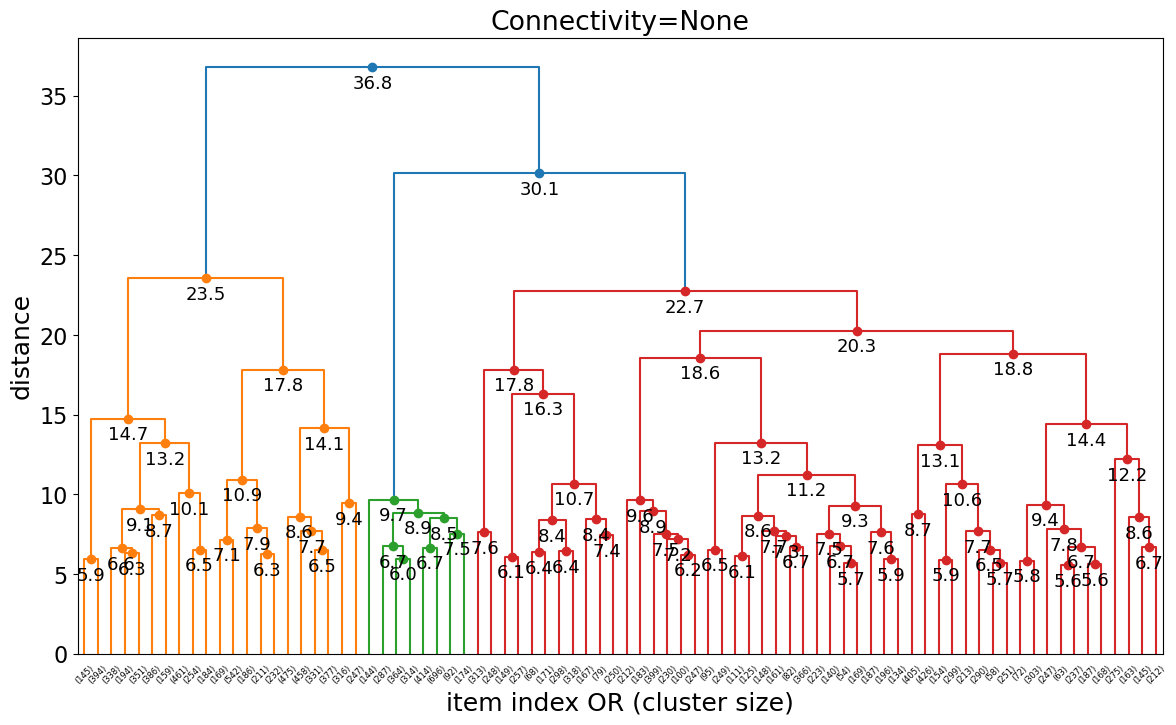

In [44]:
fig = plt.figure(figsize=(14, 8))

clustering_utils.fancy_dendrogram(
    X_linkage_coF,
    p=80,
    plot_title='Connectivity=None',
    annotate_above=X_linkage_coF['distance'].quantile(q=0.995),
    truncate_mode='lastp',
    orientation='top',
    show_leaf_counts=True, leaf_rotation=45,
    show_contracted=False,
)
plt.show()

### Get list of leaves

This should help us map a the subreddits back to a cluster. These are expected to be the index (.iloc) of the original training/input embeddings df/array.

In [255]:
from scipy.cluster.hierarchy import leaves_list

In [257]:

leaves_list(X_linkage_coF).shape

(19192,)

In [262]:
leaves_list(X_linkage_coF)

array([ 2240, 10893,  4562, ..., 12920, 10856, 13284], dtype=int32)

In [263]:
df_v_sub.reindex(leaves_list(X_linkage_coF))

,subreddit_name,subreddit_id,embeddings_0,embeddings_1,embeddings_2,embeddings_3,embeddings_4,embeddings_5,embeddings_6,embeddings_7,embeddings_8,embeddings_9,embeddings_10,embeddings_11,embeddings_12,embeddings_13,embeddings_14,embeddings_15,embeddings_16,embeddings_17,embeddings_18,embeddings_19,embeddings_20,embeddings_21,embeddings_22,embeddings_23,embeddings_24,embeddings_25,embeddings_26,embeddings_27,...,embeddings_482,embeddings_483,embeddings_484,embeddings_485,embeddings_486,embeddings_487,embeddings_488,embeddings_489,embeddings_490,embeddings_491,embeddings_492,embeddings_493,embeddings_494,embeddings_495,embeddings_496,embeddings_497,embeddings_498,embeddings_499,embeddings_500,embeddings_501,embeddings_502,embeddings_503,embeddings_504,embeddings_505,embeddings_506,embeddings_507,embeddings_508,embeddings_509,embeddings_510,embeddings_511
2240,blackmetal,t5_2rta0,-0.030863,-0.003646,-0.015832,0.001043,-0.005472,0.039872,-0.005096,-0.006556,-0.016485,-0.007334,-0.015270,-0.017965,-0.027171,-0.011230,0.013252,0.002110,0.009314,0.006173,-0.000723,0.014717,-0.002368,-0.023800,0.020743,0.030161,0.009684,-0.005734,0.027769,-0.008707,...,0.016679,-0.002643,-0.009998,0.028544,0.016577,-0.028591,-0.001944,0.003376,-0.012414,0.029788,0.007715,0.024161,0.005936,-0.006814,-0.024945,-0.001290,-0.001767,-0.000119,0.012336,-0.045209,-0.002074,0.003752,-0.017141,0.009586,0.014288,0.005845,-0.005768,-0.017853,-0.019157,0.020662
10893,metal,t5_2qhud,-0.033552,-0.008254,-0.001479,0.008445,0.004823,0.036910,-0.001406,0.000156,-0.013258,0.001922,-0.006898,-0.021458,-0.053471,-0.007361,0.016114,-0.002107,0.011065,0.015598,-0.027496,0.013425,0.001822,-0.046143,0.018047,0.044138,0.014202,-0.008228,0.027938,-0.009042,...,0.026251,-0.009545,-0.014618,0.044615,0.018228,-0.035569,0.003360,0.010948,-0.011197,0.025438,0.014474,0.032460,-0.010635,-0.017699,-0.034315,-0.011034,0.003803,-0.017878,0.004208,-0.053051,0.012989,0.008425,-0.026519,0.006160,0.012110,0.008927,0.008239,-0.018215,-0.019348,0.019343
4562,deathmetal,t5_2r5w5,-0.027550,-0.005144,0.004414,0.024724,-0.010867,0.045382,-0.001033,0.005244,-0.006169,-0.012517,-0.015211,-0.018752,-0.035537,0.001819,0.011281,0.008232,0.021654,-0.013666,-0.033664,0.013161,0.014009,-0.029463,0.016383,0.034041,0.010442,-0.007627,0.015240,-0.012125,...,0.016078,-0.000271,-0.026169,0.045701,0.026770,-0.016163,-0.010068,0.005857,-0.013097,0.013106,0.003706,0.022287,-0.010566,-0.012509,-0.012453,-0.003276,-0.014195,-0.019412,0.009148,-0.045538,-0.003971,0.009534,-0.024190,0.023898,0.008267,0.012537,0.010205,-0.012270,-0.009920,0.007721
17040,thrashmetal,t5_2s66e,-0.029017,-0.005750,0.002124,0.020491,-0.014042,0.047475,0.007391,-0.004591,-0.003478,-0.002312,-0.017702,-0.008524,-0.031729,-0.003211,0.019373,0.004815,0.015180,-0.018233,-0.033555,0.015251,0.005662,-0.027706,0.012982,0.035152,0.008013,0.004529,0.009332,-0.011246,...,0.026434,-0.016552,-0.021430,0.038019,0.026555,-0.015489,-0.002728,0.004934,-0.010947,0.009814,0.019757,0.022440,-0.016233,-0.012314,-0.009419,0.001169,-0.013652,-0.016023,0.008265,-0.050346,-0.001190,0.018446,-0.028996,0.032867,-0.002692,0.017905,0.016636,-0.013695,-0.016564,0.006150
16564,technicaldeathmetal,t5_2s8ge,-0.021700,0.017623,0.012018,0.021138,0.002594,0.033391,-0.001557,0.003301,-0.010216,-0.008666,-0.011336,-0.025759,-0.025922,0.003377,0.022342,0.015550,0.034766,-0.014407,-0.016205,0.019000,0.013199,-0.018080,0.005105,0.016612,-0.003287,-0.009015,0.011162,-0.027227,...,0.011654,0.010184,-0.008761,0.035803,0.026066,-0.019714,-0.003151,0.013481,-0.006953,0.010922,0.022413,0.022707,-0.003554,-0.036925,-0.014313,0.003801,-0.009468,-0.028545,0.013311,-0.053030,0.008424,0.008210,-0.020922,0.022723,0.024467,0.013351,0.006392,-0.019359,-0.022775,0.027806
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [254]:
# # TODO(djb): fix orientation right or left:
# #. the axis labels are flipped
# #. The distances are in the wront place
# fig = plt.figure(figsize=(12, 10))

# clustering_utils.fancy_dendrogram(
#     X_linkage_coF,
#     p=80,
#     plot_title='Connectivity=None',
#     annotate_above=X_linkage_coF['distance'].quantile(q=0.995),
#     truncate_mode='lastp',
#     orientation='right',
#     show_leaf_counts=True, 
#     # leaf_rotation=45,
#     show_contracted=False,
# )
# plt.show()

# Find optimal clusters & Get cluster labels

## Use `fcluster` to get the cluster labels

- https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/#Retrieve-the-Clusters
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.fcluster.html#scipy.cluster.hierarchy.fcluster


Primary parameters to test:
> - `t`: scalar
>    - For criteria ‘inconsistent’, ‘distance’ or ‘monocrit’, this is the threshold to apply when forming flat clusters.
>    - For ‘maxclust’ or ‘maxclust_monocrit’ criteria, this would be max number of clusters requested.
>
> - `criterion`: str, optional<br>
>    The criterion to use in forming flat clusters. This can be any of the following values:
>    - `inconsistent` :
>        - If a cluster node and all its descendants have an inconsistent value less than or equal to t, then all its leaf descendants belong to the same flat cluster. When no non-singleton cluster meets this criterion, every node is assigned to its own cluster. (Default)
>    - `distance` :
>        - Forms flat clusters so that the original observations in each flat cluster have no greater a cophenetic distance than t.
>    - `maxclust` :
>        - Finds a minimum threshold r so that the cophenetic distance between any two original observations in the same flat cluster is no more than r and no more than t flat clusters are formed.

In [45]:
from scipy.cluster.hierarchy import fcluster

## Elbow method

We sometimes we want to do elbow method +1 because there are cases where elbow method will miss a slight difference that could be big

<Figure size 1400x800 with 0 Axes>

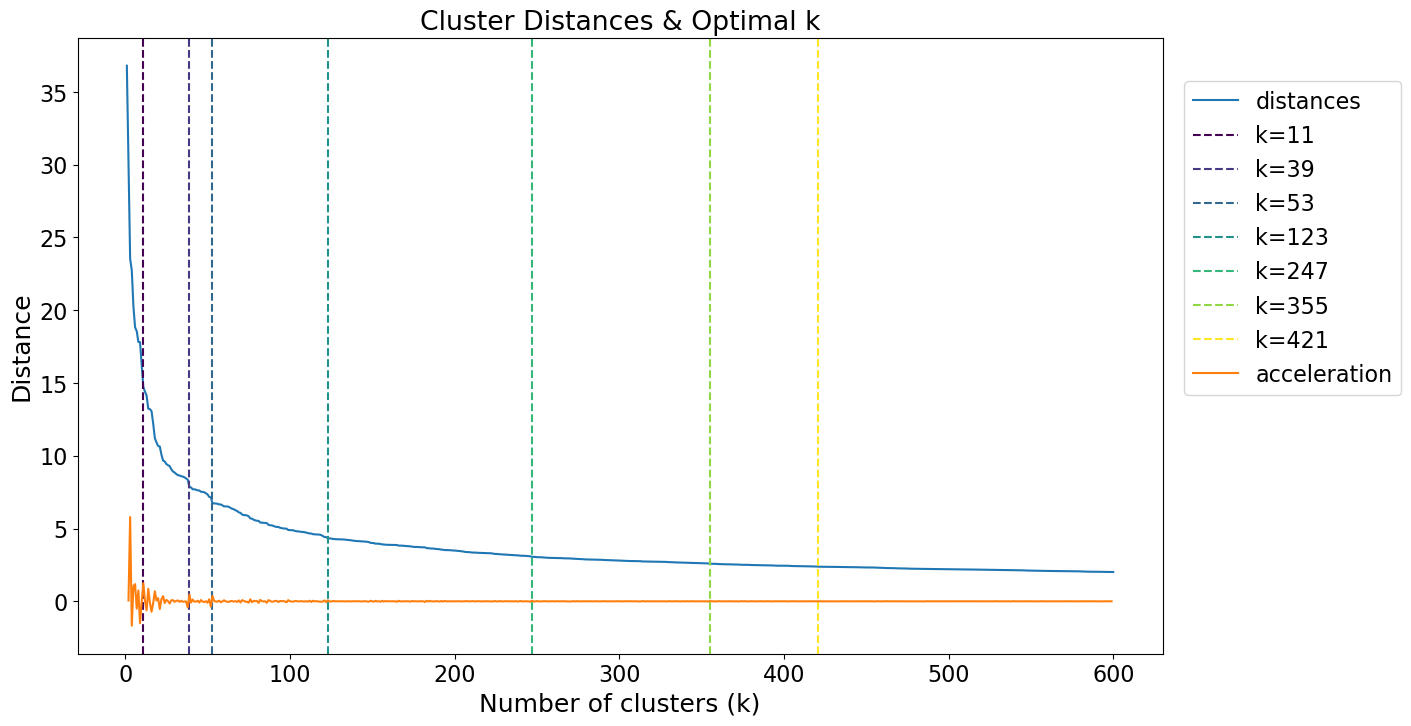

In [241]:
fig = plt.figure(figsize=(14, 8))

col_optimal_k = 'optimal_k_for_interval'
df_accel_coF, d_optimal_ks = clustering_utils.plot_elbow_and_get_k(
    X_linkage_coF,
    col_optimal_k=col_optimal_k,
    n_clusters_to_check=600,
    return_optimal_ks=True,
    # save_path=f"djb_ignore_fig2.png",
)

# df_accel_coT = clustering_utils.plot_elbow_and_get_k(
#     X_linkage_coT,
#     col_optimal_k=col_optimal_k,
#     n_clusters_to_check=600
# )

In [242]:
pd.DataFrame(d_optimal_ks).T

,k,col_prefix
010_to_020,11,011_k
020_to_050,39,039_k
050_to_100,53,053_k
100_to_200,123,123_k
200_to_300,247,247_k
300_to_400,355,355_k
400_to_600,421,421_k


In [250]:
df_accel_coF.head()

,k,acceleration,optimal_k_for_interval
0,2,0.056088,NaN
1,3,5.790447,NaN
2,4,-1.677656,NaN
3,5,1.055509,NaN
4,6,1.179514,NaN


In [251]:
# d_optimal_ks

In [252]:
# pd.DataFrame(d_optimal_ks)

In [253]:
# pd.DataFrame(d_optimal_ks).T

In [47]:
# df_accel_coF.head()

In [98]:
df_accel_coF.dropna(subset=[col_optimal_k])

,k,acceleration,optimal_k_for_interval
9,11,1.243624,010_to_020
37,39,0.467077,020_to_050
51,53,0.370633,050_to_100
121,123,0.063018,100_to_200
245,247,0.036891,200_to_300
353,355,0.016812,300_to_400
419,421,0.009343,400_to_600


In [99]:
df_accel_compare = (
    df_accel_coF
    .merge(
        df_accel_coT,
        how='outer',
        on=['k'],
        suffixes=('_coF', '_coT')
    )
)
mask_top_intervals = (
    ~df_accel_compare[f'{col_optimal_k}_coF'].isnull() |
    ~df_accel_compare[f'{col_optimal_k}_coT'].isnull()
)

style_df_numeric(
    df_accel_compare[mask_top_intervals]
    .sort_values(by=['acceleration_coF'], ascending=False).head(15)
    .reset_index(drop=True)
    ,
    float_round=4,
    l_bar_simple=['acceleration_coF', 'acceleration_coT']   
)

,k,acceleration_coF,optimal_k_for_interval_coF,acceleration_coT,optimal_k_for_interval_coT
0,11,1.2436,010_to_020,-0.2953,nan
1,39,0.4671,020_to_050,-0.1196,nan
2,53,0.3706,050_to_100,-0.0274,nan
3,123,0.0630,100_to_200,0.0017,nan
4,12,0.0529,nan,0.8335,010_to_020
5,247,0.0369,200_to_300,-0.0253,nan
6,355,0.0168,300_to_400,0.0061,nan
7,26,0.0135,nan,0.4676,020_to_050
8,421,0.0093,400_to_600,0.0061,nan
9,458,0.0016,nan,0.0104,400_to_600


In [100]:
# style_df_numeric(
#     df_accel_compare[mask_top_intervals]
#     .sort_values(by=['acceleration_coT'], ascending=False).head(15)
#     .reset_index(drop=True)
#     ,
#     float_round=4,
#     l_bar_simple=['acceleration_coF', 'acceleration_coT']   
# )

## `inconsistent` method

This one requires that we set a value for `t`: threshold. which seems somewhat arbitrary.

This one seems harder to optimize... so I prob won't apply it

In [51]:
%%time

labels_ = fcluster(X_linkage_coF, t=8, criterion='inconsistent', depth=10)


print(f"Label count: {len(set(labels_)):,.0f}")
(
    pd.DataFrame([Counter(labels_)], index=['subreddit_count'])
    .T
    .rename_axis(index='cluster_id')
    .sort_values(by=['subreddit_count'], ascending=False)
    .head(9)
)

Label count: 89
CPU times: user 106 ms, sys: 2.89 ms, total: 109 ms
Wall time: 108 ms


,subreddit_count
cluster_id,
84,655
79,599
22,475
11,461
75,426
57,399
26,377
67,366
41,353


In [52]:
%%time

labels_ = fcluster(X_linkage_coF, t=8, criterion='inconsistent', depth=8)


print(f"Label count: {len(set(labels_)):,.0f}")
(
    pd.DataFrame([Counter(labels_)], index=['subreddit_count'])
    .T
    .rename_axis(index='cluster_id')
    .sort_values(by=['subreddit_count'], ascending=False)
    .head(9)
)

Label count: 32
CPU times: user 105 ms, sys: 623 µs, total: 106 ms
Wall time: 105 ms


,subreddit_count
cluster_id,
26,2096
8,1641
23,1371
22,1351
7,1340
30,1277
29,1265
16,1110
2,883


In [53]:
# %%time

# max_d = 5
# labels_1 = fcluster(X_linkage_coF, max_d, criterion='distance')

# labels_ = labels_1


# print(f"Label count: {len(set(labels_)):,.0f}")

# (
#     pd.DataFrame([Counter(labels_)], index=['subreddit_count'])
#     .T
#     .rename_axis(index='cluster_id')
#     .sort_values(by=['subreddit_count'], ascending=False)
#     .head(9)
# )

### Check same number of clusters as training data

If we pull 65 clusters (same as training) we should get the same clusters. HOWEVER, the index/id for the clusters is not guaranteed to be the same.

Below we can see that the subreddit counts for the top 9 subs are the same. However, their IDs are different (as expected).

In [54]:
k=65
labels_2 = fcluster(X_linkage_coF, k, criterion='maxclust')

labels_ = labels_2

print(f"Label count: {len(set(labels_)):,.0f}")
(
    pd.DataFrame([Counter(labels_)], index=['subreddit_count'])
    .T
    .rename_axis(index='cluster_id')
    .sort_values(by=['subreddit_count'], ascending=False)
    .head(9)
)

Label count: 65


,subreddit_count
cluster_id,
23,696
21,678
3,545
10,542
1,539
13,475
6,461
14,458
54,453


In [55]:
%%time
labels_ = cls_agg_ward_cosine_coF.labels_

print(f"Label count: {len(set(labels_)):,.0f}")
(
    pd.DataFrame([Counter(labels_)], index=['subreddit_count'])
    .T
    .rename_axis(index='cluster_id')
    .sort_values(by=['subreddit_count'], ascending=False)
    .head(9)
)

Label count: 65
CPU times: user 12.3 ms, sys: 148 µs, total: 12.4 ms
Wall time: 11.8 ms


,subreddit_count
cluster_id,
48,696
9,678
2,545
26,542
5,539
7,475
22,461
43,458
21,453


In [56]:
k=350
labels_ = fcluster(X_linkage_coF, k, criterion='maxclust')

print(f"Label count: {len(set(labels_)):,.0f}")
df_lbl_value_counts = (
    pd.DataFrame([Counter(labels_)], index=['subreddit_count'])
    .T
    .rename_axis(index='cluster_id')
    .sort_values(by=['subreddit_count'], ascending=False)
)
display(df_lbl_value_counts.head(10))
display(df_lbl_value_counts.tail(10))

Label count: 350


,subreddit_count
cluster_id,
269,211
114,201
20,195
129,173
119,169
53,168
55,160
280,154
5,151


,subreddit_count
cluster_id,
327,13
265,13
77,13
328,12
252,12
18,12
323,12
78,11
300,9


In [57]:
df_lbl_value_counts['subreddit_count'].describe()

count    350.000000
mean      54.834286
std       35.416894
min        8.000000
25%       30.000000
50%       47.000000
75%       69.000000
max      211.000000
Name: subreddit_count, dtype: float64

# Create df with the labels at different break points

We need the labels in order to compute metrics - w or w/o ground truth. So it's easier to keep track of those lables in a single df

In [85]:
np.arange(10, 260, 10)

array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250])

In [107]:
df_labels_coF = df_v_sub[l_ix_sub].copy()

s_k_to_evaluate = set(np.arange(10, 260, 10))

# add the 'optimal' k_ values:
for interval_ in df_accel_coF[col_optimal_k].dropna().unique():
    s_k_to_evaluate.add(df_accel_coF[df_accel_coF[col_optimal_k] == interval_]['k'].values[0])

for k_ in tqdm(sorted(s_k_to_evaluate)):
    df_labels_coF[f"{k_:03d}_k_labels"] = fcluster(X_linkage_coF, k_, criterion='maxclust')

df_labels_coF.shape

100%|██████████| 32/32 [00:01<00:00, 22.04it/s]


(19192, 34)

In [108]:
df_labels_coF.head()

,subreddit_name,subreddit_id,010_k_labels,011_k_labels,020_k_labels,030_k_labels,039_k_labels,040_k_labels,050_k_labels,053_k_labels,060_k_labels,070_k_labels,080_k_labels,090_k_labels,100_k_labels,110_k_labels,120_k_labels,123_k_labels,130_k_labels,140_k_labels,150_k_labels,160_k_labels,170_k_labels,180_k_labels,190_k_labels,200_k_labels,210_k_labels,220_k_labels,230_k_labels,240_k_labels,247_k_labels,250_k_labels,355_k_labels,421_k_labels
0,0sanitymemes,t5_2qlzfy,4,4,8,12,15,16,17,18,21,25,27,31,35,37,40,41,42,45,47,51,57,60,64,67,71,75,77,81,84,84,118,138
1,0xpolygon,t5_2qgijx,5,5,9,13,17,18,20,21,24,28,30,34,39,41,44,45,46,49,52,56,62,65,69,74,78,82,84,88,91,91,131,153
2,1000lbsisters,t5_2axvbl,1,1,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,4,4,5,5,5,5,5,5,6,6,6,6,6,9,11
3,100gecs,t5_131dor,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,4,4,4,4,4,5,6
4,100kanojo,t5_2asd3o,1,1,3,4,5,5,5,5,6,7,8,8,9,9,9,9,9,10,11,14,15,16,16,17,17,19,19,20,21,21,30,37


In [109]:
df_labels_coF.tail()

,subreddit_name,subreddit_id,010_k_labels,011_k_labels,020_k_labels,030_k_labels,039_k_labels,040_k_labels,050_k_labels,053_k_labels,060_k_labels,070_k_labels,080_k_labels,090_k_labels,100_k_labels,110_k_labels,120_k_labels,123_k_labels,130_k_labels,140_k_labels,150_k_labels,160_k_labels,170_k_labels,180_k_labels,190_k_labels,200_k_labels,210_k_labels,220_k_labels,230_k_labels,240_k_labels,247_k_labels,250_k_labels,355_k_labels,421_k_labels
19187,zurich_coffee,t5_50hqoz,8,9,15,22,29,30,37,40,44,53,56,63,71,76,82,84,87,95,102,111,119,125,132,139,146,153,160,167,172,173,249,293
19188,zwift,t5_33t8j,7,8,12,19,25,26,31,33,36,43,46,52,59,63,68,70,73,80,86,93,101,106,112,119,126,131,136,142,146,147,210,250
19189,zyn,t5_38nx2,8,9,14,21,28,29,35,37,40,49,52,58,65,70,75,77,80,87,94,102,110,115,122,129,136,142,148,155,160,161,228,271
19190,zyramains,t5_35la7,4,4,8,11,13,14,15,16,17,21,22,26,29,30,31,32,33,35,36,40,46,49,52,55,58,62,63,65,68,68,96,110
19191,zyzz,t5_2sosg,8,9,14,21,27,28,33,35,38,46,49,55,62,66,71,73,76,83,89,96,104,109,115,122,129,134,140,147,152,153,218,259


In [110]:
df_labels_coT = df_v_sub[l_ix_sub].copy()

for k_ in tqdm(sorted(s_k_to_evaluate)):
    df_labels_coT[f"{k_:03d}_k_labels"] = fcluster(X_linkage_coT, k_, criterion='maxclust')

df_labels_coT.shape

100%|██████████| 32/32 [00:01<00:00, 22.12it/s]


(19192, 34)

In [111]:
# df_labels_coT.head()

In [112]:
# df_accel_coF.dropna(subset=[col_optimal_k])

In [113]:
# df_accel_coT.dropna(subset=[col_optimal_k])

# Test metrics

Let's test metrics for these intervals:
- 010_to_020 (maybe?)
- 050_to_100
- 300_to_500

If these works, then all other intervals should work too

In [690]:
intervals_to_test = ['020_to_050', '300_to_500']

## Metrics WITHOUT ground truth

- [Calinski-Harabasz](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.calinski_harabasz_score.html#sklearn.metrics.calinski_harabasz_score)
- [Silhoutte](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html#sklearn.metrics.silhouette_score)
    - [Demo with images](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py)

### Silhoutte per sample

Best to calculate per sample and we can roll up to aggregate (mean, std, median) on our own

In [115]:
from tqdm import tqdm
from sklearn.metrics import calinski_harabasz_score, silhouette_score, silhouette_samples
import matplotlib.cm as cm


In [136]:
del df_silhouette_samples_coF

In [137]:
%%time

# Compute the silhouette scores for each sample
# for interval_ in tqdm(intervals_to_test):
# df_silhouette_samples_coF = df_v_sub[l_ix_sub].copy()

for interval_ in tqdm(df_accel_coF[col_optimal_k].dropna().unique()):
    k_ = df_accel_coF[df_accel_coF[col_optimal_k] == interval_]['k'].values[0]
    
    df_labels_coF[f"{k_:03d}_k_silhouette_score_cosine"] = silhouette_samples(
        df_v_sub[l_cols_embeddings], 
        df_labels_coF[f"{k_:03d}_k_labels"],
        metric='cosine',
    )
    
#     df_labels_coF[f"{interval_}_silhouette_score_euclidean"] = silhouette_samples(
#         df_v_sub[l_cols_embeddings], 
#         df_labels_coF[f"{interval_}_labels"],
#         metric='euclidean',
#     )

100%|██████████| 7/7 [00:33<00:00,  4.72s/it]

CPU times: user 5min 9s, sys: 23min 9s, total: 28min 18s
Wall time: 33.1 s


In [118]:
# %%time

# # Compute the silhouette scores for each sample
# for interval_ in tqdm(intervals_to_test):
#     df_labels_coT[f"{interval_}_silhouette_score_cosine"] = silhouette_samples(
#         df_v_sub[l_cols_embeddings], 
#         df_labels_coT[f"{interval_}_labels"],
#         metric='cosine',
#     )
#     df_labels_coT[f"{interval_}_silhouette_score_euclidean"] = silhouette_samples(
#         df_v_sub[l_cols_embeddings], 
#         df_labels_coT[f"{interval_}_labels"],
#         metric='euclidean',
#     )

In [138]:
df_silhouette_summary_coF = df_labels_coF[[c for c in df_labels_coF.columns if 'silhouette_score' in c]].describe().T

# add k as a column so we can plot it
df_silhouette_summary_coF['k'] = df_silhouette_summary_coF.index.str.split('_k_').str[0].astype(int)

style_df_numeric(
    df_silhouette_summary_coF,
    float_round=3,
)

,count,mean,std,min,25%,50%,75%,max,k
011_k_silhouette_score_cosine,"19,192",0.094,0.152,-0.537,-0.004,0.097,0.190,0.561,11
039_k_silhouette_score_cosine,"19,192",0.084,0.200,-0.541,-0.066,0.068,0.231,0.655,39
053_k_silhouette_score_cosine,"19,192",0.083,0.204,-0.541,-0.070,0.063,0.235,0.655,53
123_k_silhouette_score_cosine,"19,192",0.084,0.199,-0.515,-0.060,0.077,0.222,0.793,123
247_k_silhouette_score_cosine,"19,192",0.089,0.200,-0.535,-0.054,0.082,0.223,0.772,247
355_k_silhouette_score_cosine,"19,192",0.097,0.198,-0.579,-0.044,0.090,0.227,0.780,355
421_k_silhouette_score_cosine,"19,192",0.098,0.200,-0.579,-0.048,0.089,0.230,0.838,421


<AxesSubplot:xlabel='k', ylabel='mean'>

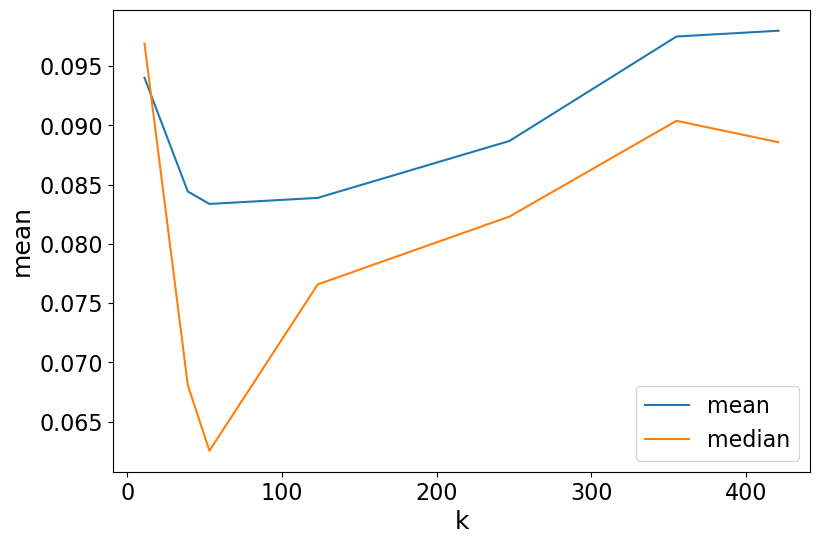

In [139]:
sns.lineplot(data=df_silhouette_summary_coF, x='k', y='mean', label='mean')
sns.lineplot(data=df_silhouette_summary_coF, x='k', y='50%', label='median')

In [140]:
# # TODO(djb): for each k-bin & score type: log mean, std, & median to mlflow
# style_df_numeric(
#     df_labels_coF[[c for c in df_labels_coF.columns if '_silhouette_score' in c]].describe().T,
#     float_round=3,
# )

In [141]:
# # TODO(djb): log mean, std, & median to mlflow
# style_df_numeric(
#     df_labels_coT[[c for c in df_labels_coT.columns if '_silhouette_score' in c]].describe().T,
#     float_round=3,
# )

In [143]:
df_labels_coF.head()

,subreddit_name,subreddit_id,010_k_labels,011_k_labels,020_k_labels,030_k_labels,039_k_labels,040_k_labels,050_k_labels,053_k_labels,060_k_labels,070_k_labels,080_k_labels,090_k_labels,100_k_labels,110_k_labels,120_k_labels,123_k_labels,130_k_labels,140_k_labels,150_k_labels,160_k_labels,170_k_labels,180_k_labels,190_k_labels,200_k_labels,210_k_labels,220_k_labels,230_k_labels,240_k_labels,247_k_labels,250_k_labels,355_k_labels,421_k_labels,011_k_silhouette_score_cosine,039_k_silhouette_score_cosine,053_k_silhouette_score_cosine,123_k_silhouette_score_cosine,247_k_silhouette_score_cosine,355_k_silhouette_score_cosine,421_k_silhouette_score_cosine
0,0sanitymemes,t5_2qlzfy,4,4,8,12,15,16,17,18,21,25,27,31,35,37,40,41,42,45,47,51,57,60,64,67,71,75,77,81,84,84,118,138,0.034957,-0.007438,-0.035779,-0.016122,-0.015568,0.083026,0.083026
1,0xpolygon,t5_2qgijx,5,5,9,13,17,18,20,21,24,28,30,34,39,41,44,45,46,49,52,56,62,65,69,74,78,82,84,88,91,91,131,153,0.339129,0.311604,0.275031,0.275031,0.076721,0.089723,0.102579
2,1000lbsisters,t5_2axvbl,1,1,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,4,4,5,5,5,5,5,5,6,6,6,6,6,9,11,0.089267,-0.137784,-0.137784,-0.083912,-0.072849,-0.155199,-0.175047
3,100gecs,t5_131dor,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,4,4,4,4,4,5,6,0.115213,0.303053,0.303053,0.189936,-0.142190,-0.140902,-0.140902
4,100kanojo,t5_2asd3o,1,1,3,4,5,5,5,5,6,7,8,8,9,9,9,9,9,10,11,14,15,16,16,17,17,19,19,20,21,21,30,37,0.167355,0.371361,0.371361,0.160672,0.281248,0.122117,0.122117


In [149]:
# df_labels_coF[[c for c in df_labels_coF.columns if 'k_labels' in c][:2]]

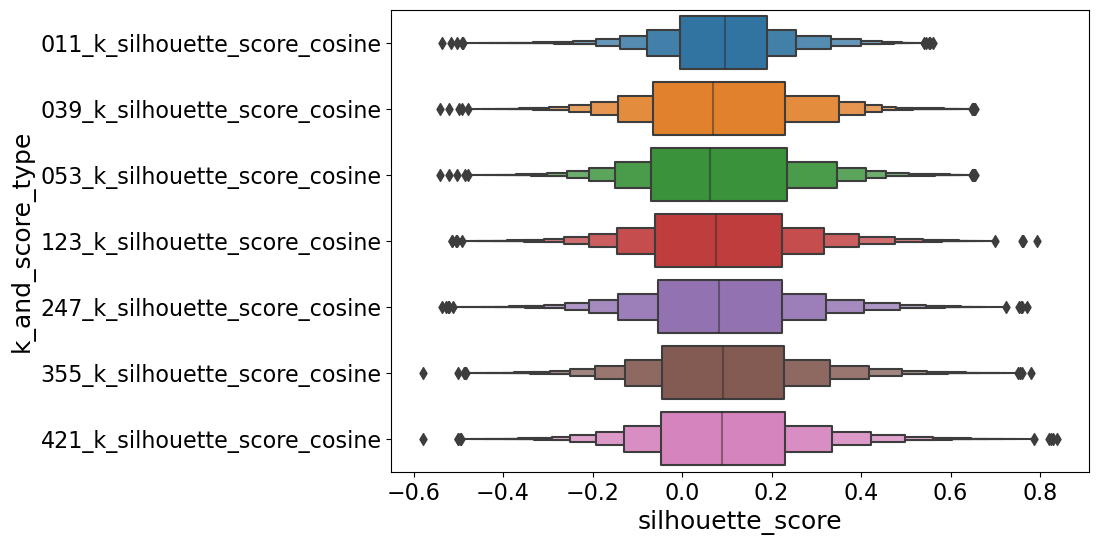

In [145]:
# we'll need to concat the dfs to show the plots on the same axis
col_score_type = 'k_and_score_type'
col_score = 'silhouette_score'
df_plot = (
    df_labels_coF[[c for c in df_labels_coF.columns if '_silhouette_score' in c]]
    .stack()
    .reset_index()
    .rename(columns={'level_0': 'index',
                     'level_1': col_score_type,
                     0: col_score,
                     })
)


ax = sns.boxenplot(data=df_plot, 
                   y=col_score_type,
                   x=col_score,
                  )

# plt.legend()

In [156]:
(
    df_labels_coF.groupby(col_labels)[col_sil_score]
    .describe()
    .sort_values(by=['50%'], ascending=False)
)

,count,mean,std,min,25%,50%,75%,max
011_k_labels,,,,,,,,
6,406.0,0.401870,0.099762,-0.034696,0.362184,0.434386,0.466635,0.553917
5,561.0,0.371008,0.099189,-0.064550,0.317455,0.385265,0.445453,0.560777
4,2485.0,0.228841,0.111925,-0.341945,0.168218,0.239875,0.310037,0.445599
2,1340.0,0.191295,0.075662,-0.253131,0.149917,0.208147,0.243423,0.344591
10,2096.0,0.114956,0.115744,-0.347459,0.036698,0.138043,0.208081,0.312578
8,1371.0,0.106953,0.095419,-0.332559,0.055858,0.127945,0.176489,0.273890
1,2866.0,0.090984,0.099536,-0.343416,0.032585,0.111682,0.165656,0.274238
7,1351.0,0.040916,0.112519,-0.351121,-0.032827,0.056080,0.131117,0.248941
11,2072.0,0.022478,0.094710,-0.328601,-0.040425,0.039567,0.093617,0.230086


  0%|          | 0/19192 [00:00<?, ?it/s]

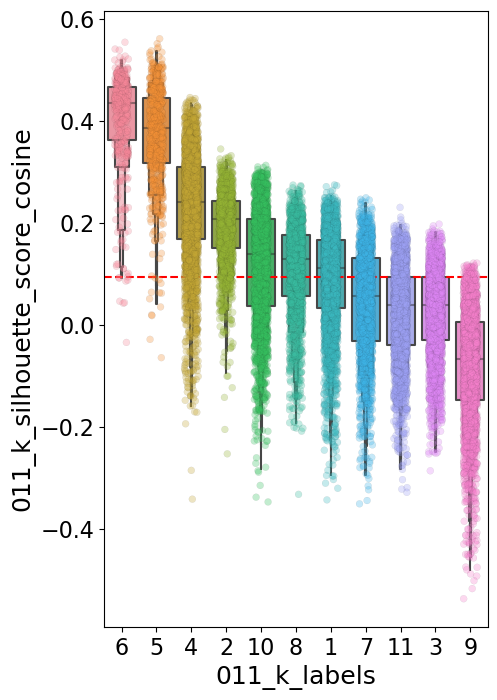

  0%|          | 1/19192 [00:00<3:21:59,  1.58it/s]

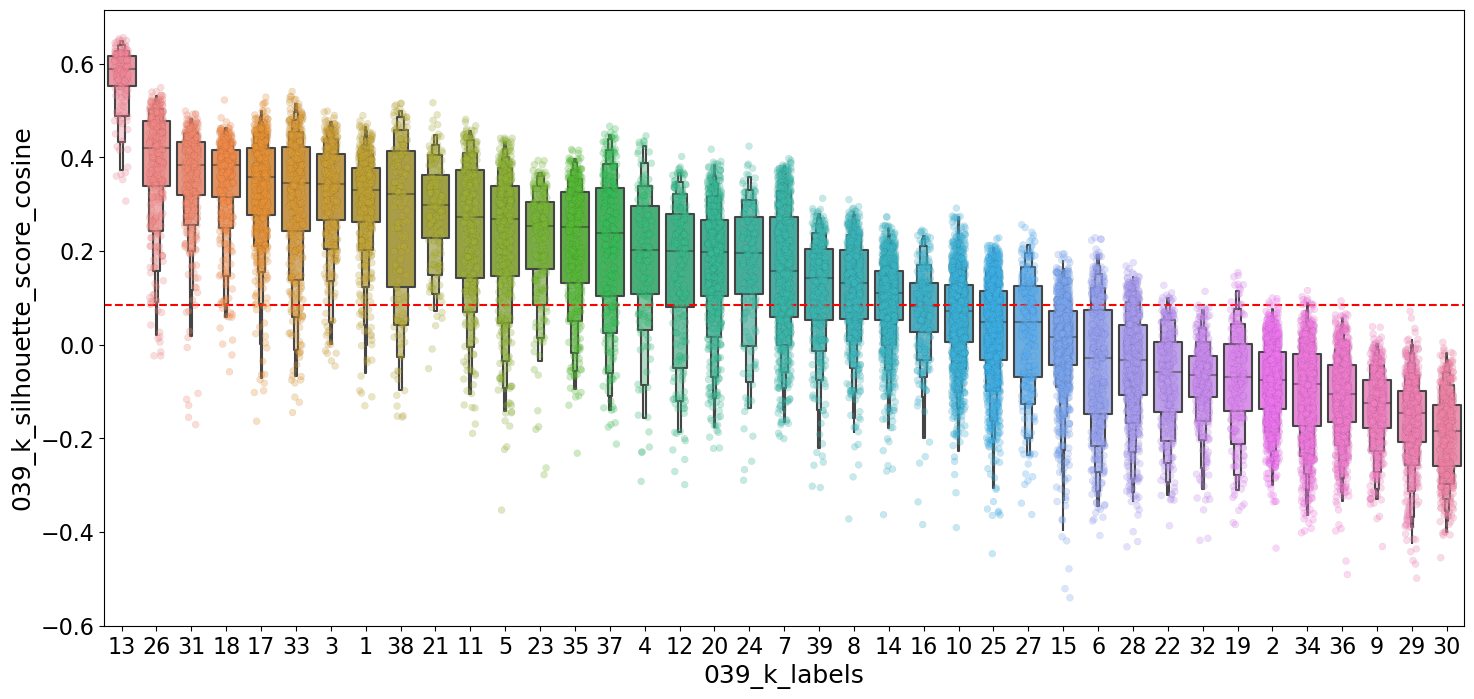

  0%|          | 2/19192 [00:01<5:08:08,  1.04it/s]

CPU times: user 2.15 s, sys: 322 ms, total: 2.47 s
Wall time: 1.93 s


In [157]:
%%time

for col_sil_score in tqdm(df_labels_coF[[c for c in df_labels_coF.columns if '_silhouette_score_cosine' in c][:2]]):
    col_labels = col_sil_score.replace('_silhouette_score_cosine', '_labels')
    # col_sil_score = col_labels.replace('_labels', '_silhouette_score_cosine')
    silh_avg = df_labels_coF[col_sil_score].mean()

    
    df_clust_agg_desc = (
        df_labels_coF.groupby(col_labels)[col_sil_score]
        .describe()
        .sort_values(by=['50%'], ascending=False)
    )
    
    n_clusters = df_labels_coF[col_labels].nunique()

    fig = plt.figure(figsize=(.45 * n_clusters, 8))

    ax = sns.stripplot(
        data=df_labels_coF, y=col_sil_score, x=col_labels, 
        jitter=0.2, alpha=0.3, edgecolor='#191919', linewidth=0.1,
        order=df_clust_agg_desc.index,
    )

    ax = sns.boxenplot(
        data=df_labels_coF, y=col_sil_score, x=col_labels,
        showfliers=False,
        order=df_clust_agg_desc.index,
    )

    # The vertical line for average silhouette score of all the values
    ax.axhline(y=silh_avg, color="red", linestyle="--")
    plt.show()

# Metrics WITH ground truth


### Known labels
For these I'll use subreddits with known labels to check the clusters
- rating name
- primary topic

I'll need to exclude subs that don't have labels, otherwise we'll get some noise



In [158]:
# value_counts_and_pcts(df_subs['rating_name'])

In [161]:
# df_emb_svd2_meta['primary_topic'].isnull().sum()

In [160]:
df_subs['primary_topic'].isnull().sum()

3262

In [673]:
# df_emb_svd2_meta['primary_topic'].value_counts(dropna=False)

In [732]:
# value_counts_and_pcts(df_subs['primary_topic'], top_n=20)

In [694]:
# df_emb_svd2_meta['primary_topic'].value_counts().tail(20)

### Metrics
These are the metrics to test:
- **adjusted** rand index
    - We want the adjusted version because it's more robust to randomness
- **adjusted** mutual information score
    - We want the adjusted version because it's more robust to randomness
- **homogeneity**

[Adjusted scores demo (in sklearn)](https://scikit-learn.org/stable/auto_examples/cluster/plot_adjusted_for_chance_measures.html#sphx-glr-auto-examples-cluster-plot-adjusted-for-chance-measures-py)

## Convert cluster labels to known labels / Create confusion matrix with clusters + labels

In order to use the metrics with ground-truth scores, we need to convert the cluster IDs (intergers) into known labels.

As a naive baseline I'm saying that each cluster should inherit the label of the majority of subreddits in the cluster.

Example: 
- [Visualization with hierarchical clustering and t-SNE](https://goodboychan.github.io/python/datacamp/machine_learning/visualization/2020/06/01/02-Visualization-with-hierarchical-clustering-and-t-SNE.html)

In [162]:
from sklearn.metrics import (
    classification_report, 
    adjusted_mutual_info_score, adjusted_rand_score,
    homogeneity_score,
)


d_metrics_and_names = {
    'adjusted_mutual_info_score': adjusted_mutual_info_score, 
    'adjusted_rand_score': adjusted_rand_score,
    'homogeneity_score': homogeneity_score,
}

In [164]:
df_labels_coF_meta.head()

,subreddit_name,subreddit_id,010_k_labels,011_k_labels,020_k_labels,030_k_labels,039_k_labels,040_k_labels,050_k_labels,053_k_labels,060_k_labels,070_k_labels,080_k_labels,090_k_labels,100_k_labels,110_k_labels,120_k_labels,123_k_labels,130_k_labels,140_k_labels,150_k_labels,160_k_labels,170_k_labels,180_k_labels,190_k_labels,200_k_labels,210_k_labels,220_k_labels,230_k_labels,240_k_labels,247_k_labels,250_k_labels,355_k_labels,421_k_labels,011_k_silhouette_score_cosine,039_k_silhouette_score_cosine,053_k_silhouette_score_cosine,123_k_silhouette_score_cosine,247_k_silhouette_score_cosine,355_k_silhouette_score_cosine,421_k_silhouette_score_cosine,primary_topic,400_to_600-predicted-primary_topic_x,400_to_600-predicted-primary_topic_y
0,0sanitymemes,t5_2qlzfy,4,4,8,12,15,16,17,18,21,25,27,31,35,37,40,41,42,45,47,51,57,60,64,67,71,75,77,81,84,84,118,138,0.034957,-0.007438,-0.035779,-0.016122,-0.015568,0.083026,0.083026,Internet Culture and Memes,Gaming,Gaming
1,0xpolygon,t5_2qgijx,5,5,9,13,17,18,20,21,24,28,30,34,39,41,44,45,46,49,52,56,62,65,69,74,78,82,84,88,91,91,131,153,0.339129,0.311604,0.275031,0.275031,0.076721,0.089723,0.102579,Crypto,Crypto,Crypto
2,1000lbsisters,t5_2axvbl,1,1,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,4,4,5,5,5,5,5,5,6,6,6,6,6,9,11,0.089267,-0.137784,-0.137784,-0.083912,-0.072849,-0.155199,-0.175047,Television,Music,Music
3,100gecs,t5_131dor,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,4,4,4,4,4,5,6,0.115213,0.303053,0.303053,0.189936,-0.142190,-0.140902,-0.140902,Music,Music,Music
4,100kanojo,t5_2asd3o,1,1,3,4,5,5,5,5,6,7,8,8,9,9,9,9,9,10,11,14,15,16,16,17,17,19,19,20,21,21,30,37,0.167355,0.371361,0.371361,0.160672,0.281248,0.122117,0.122117,Anime,Music,Music


In [285]:
# df_subs.head()

In [203]:
# [c for c in df_labels_coF_meta.columns if '_k_labels' in c]

In [206]:
d_df_crosstab_labels = dict()
d_metrics = dict()
val_fill_pred_nulls = 'Meta/Reddit'

l_cols_ground_truth = [
    # 'rating_name',
    'primary_topic',
]

df_labels_coF_meta = df_labels_coF.merge(
    df_subs[l_ix_sub + l_cols_ground_truth],
    how='left',
    on=l_ix_sub,
).copy()

# df_labels_coT_meta = df_labels_coT.merge(
#     df_subs[l_ix_sub + l_cols_ground_truth],
#     how='left',
#     on=l_ix_sub,
# ).copy()

l_cols_predicted = list()
l_metrics_for_df = list()


# for interval_ in tqdm(intervals_to_test):
for col_cls_labels in tqdm([c for c in df_labels_coF_meta.columns if '_k_labels' in c], mininterval=.8,):
    k_int = int(col_cls_labels.split('_k_')[0])
    k_col_prefix = col_cls_labels.replace('_labels', '')
    print(f"=== k: {k_col_prefix} ===")
    # col_cls_labels = f"{interval_}_labels"
    
    d_df_crosstab_labels[col_cls_labels] = dict()
    d_metrics[col_cls_labels] = dict()
    
    for c_tl in l_cols_ground_truth:
        # For some reason the nulls in this table are the string 'null'! ugh
        mask_not_null_gt = ~(
            (df_labels_coF_meta[c_tl].isnull()) |
            (df_labels_coF_meta[c_tl] == 'null')
        )
        # print(f"  Nulls: {(~mask_not_null_gt).sum():,.0f}")
        d_df_crosstab_labels[col_cls_labels][c_tl] = pd.crosstab(
            df_labels_coF_meta[mask_not_null_gt][col_cls_labels], 
            df_labels_coF_meta[mask_not_null_gt][c_tl]
        )
        
        # Create new predicted column
        col_pred_ = f"{k_col_prefix}-predicted-{c_tl}"
        l_cols_predicted.append(col_pred_)
        df_labels_coF_meta = df_labels_coF_meta.merge(
            (
                d_df_crosstab_labels[col_cls_labels][c_tl]
                # .drop('null', axis=1)
                .idxmax(axis=1)
                .to_frame()
                .rename(columns={0: col_pred_})
            ),
            how='left',
            left_on=col_cls_labels,
            right_index=True,
        )
        
        # Should be rare, but fill just in case?
        # df_labels_coF_meta[col_pred_] = df_labels_coF_meta[col_pred_].fillna(val_fill_pred_nulls)
        
        # =====================
        # Calculate metrics:
        # ===
#         print(
#             classification_report(
#                 y_true=df_labels_coF_meta[mask_not_null_gt][c_tl],
#                 y_pred=df_labels_coF_meta[mask_not_null_gt][col_pred_],
#                 zero_division=0,
#             )
#         )

        d_metrics_this_split = {
            'predicted_col': col_cls_labels,
            'truth_col': c_tl,
            'k': k_int,
        }
        for m_name, metric_ in d_metrics_and_names.items():

            try:
                d_metrics_this_split[m_name] = metric_(
                    y_true=df_labels_coF_meta[mask_not_null_gt][c_tl],
                    y_pred=df_labels_coF_meta[mask_not_null_gt][col_pred_],
                )
            except TypeError:
                d_metrics_this_split[m_name] = metric_(
                    labels_true=df_labels_coF_meta[mask_not_null_gt][c_tl],
                    labels_pred=df_labels_coF_meta[mask_not_null_gt][col_pred_],
                )
        l_metrics_for_df.append(d_metrics_this_split)
#         print(f"  Metrics:\n{l_metrics_for_df}")


  0%|          | 0/32 [00:00<?, ?it/s]

=== k: 010_k ===
=== k: 011_k ===
=== k: 020_k ===
=== k: 030_k ===


 12%|█▎        | 4/32 [00:00<00:06,  4.29it/s]

=== k: 039_k ===
=== k: 040_k ===
=== k: 050_k ===
=== k: 053_k ===


 25%|██▌       | 8/32 [00:01<00:05,  4.01it/s]

=== k: 060_k ===
=== k: 070_k ===
=== k: 080_k ===
=== k: 090_k ===


 38%|███▊      | 12/32 [00:03<00:05,  3.84it/s]

=== k: 100_k ===
=== k: 110_k ===
=== k: 120_k ===
=== k: 123_k ===


 50%|█████     | 16/32 [00:04<00:04,  3.70it/s]

=== k: 130_k ===
=== k: 140_k ===
=== k: 150_k ===


 59%|█████▉    | 19/32 [00:05<00:03,  3.63it/s]

=== k: 160_k ===
=== k: 170_k ===
=== k: 180_k ===


 69%|██████▉   | 22/32 [00:05<00:02,  3.53it/s]

=== k: 190_k ===
=== k: 200_k ===
=== k: 210_k ===


 78%|███████▊  | 25/32 [00:06<00:02,  3.47it/s]

=== k: 220_k ===
=== k: 230_k ===
=== k: 240_k ===


 88%|████████▊ | 28/32 [00:07<00:01,  3.38it/s]

=== k: 247_k ===
=== k: 250_k ===
=== k: 355_k ===


 97%|█████████▋| 31/32 [00:08<00:00,  3.31it/s]

=== k: 421_k ===


100%|██████████| 32/32 [00:09<00:00,  3.52it/s]


In [207]:
df_supervised_metrics_coF = pd.DataFrame(l_metrics_for_df)
df_supervised_metrics_coF.shape

(32, 6)

In [208]:
df_supervised_metrics_coF.head()

,predicted_col,truth_col,k,adjusted_mutual_info_score,adjusted_rand_score,homogeneity_score
0,010_k_labels,primary_topic,10,0.429567,0.295511,0.353170
1,011_k_labels,primary_topic,11,0.442357,0.302893,0.367152
2,020_k_labels,primary_topic,20,0.507879,0.409205,0.453614
3,030_k_labels,primary_topic,30,0.525460,0.457105,0.490058
4,039_k_labels,primary_topic,39,0.537235,0.471473,0.512068


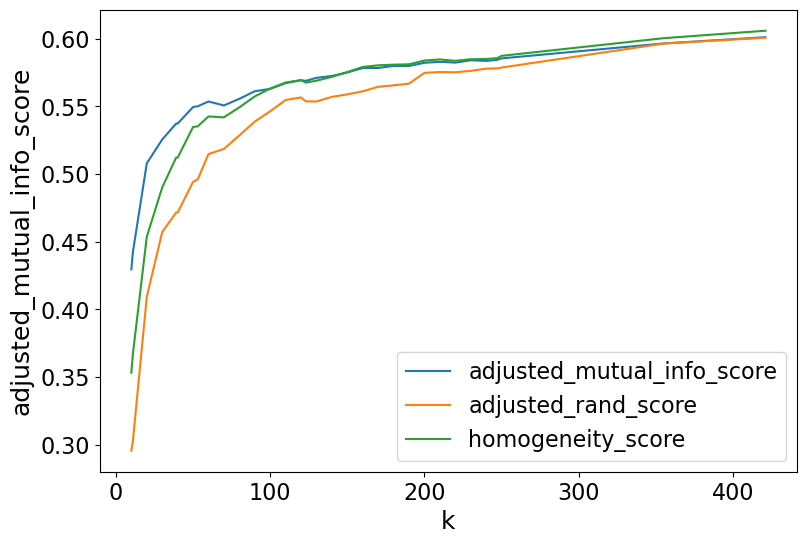

In [211]:
for c_ in [c for c in df_supervised_metrics_coF.columns if c.endswith('_score')]:
    sns.lineplot(data=df_supervised_metrics_coF, x='k', y=c_, label=c_)

In [735]:
# df_labels_coF_meta.head()

### Add leaves list order

This fxn gives us the sort order from the dendrogram, so if we sort subreddits by it, we should see similar subreddits next to each other.

This was a special case where we could easily merge on index because the df_embeddings (df_v_sub) had an integer index that was intact.

However, we can't assume that we'll have an intact index or that it'll be increasing to merge it back to to the embeddings. maybe the safest/easiest thing is to reset the index of the df_labels.

In [274]:
df_leaves_order = pd.DataFrame(
    {'index': leaves_list(X_linkage_coF)},
)
df_leaves_order.index.name = 'model_leaves_list_order_left_to_right'
df_leaves_order = (
    df_leaves_order
    .reset_index()
    .set_index('index')
)
df_leaves_order.head()

,model_leaves_list_order_left_to_right
index,
2240,0
10893,1
4562,2
17040,3
16564,4


In [349]:
df_leaves_order = pd.DataFrame(
    {
        'model_leaves_list_order_left_to_right': range(len(df_v_sub))
    },
    index=leaves_list(X_linkage_coF),
)

df_leaves_order.head()

,model_leaves_list_order_left_to_right
2240,0
10893,1
4562,2
17040,3
16564,4


In [350]:
df_labels_coF_meta.index.to_series().describe()

count    19192.000000
mean      9595.500000
std       5540.397519
min          0.000000
25%       4797.750000
50%       9595.500000
75%      14393.250000
max      19191.000000
dtype: float64

In [280]:
df_labels_coF_meta = (
    df_leaves_order
    .merge(
        df_labels_coF_meta,
        how='right',
        left_index=True,
        right_index=True,
    )
)

In [714]:
# df_labels_coF_meta[
#     l_ix_sub + l_cols_ground_truth + l_cols_predicted + 
#     [c for c in df_labels_coF_meta.columns if any([int_ in c for int_ in intervals_to_test])]
# ]

In [172]:
# l_cols_pred_optimal = list()
# l_cols_labels_optimal = list()
# df_

In [282]:
l_subreddit_names_check = [
    'de',
    'mexico',
    'berlin',

    
    'fussball',
    'futbol',
    
    'kochen',
    'vegan',
    'carnivore',
    
    'astrology',
    
    'memexico',
    'ich_iel',
    'me_irl',
    
    'reggaeton',
    'opera',
    
    'todayilearned',
    'heuteLernteich',
    'serialkillers',
    
]

# use reindex + leaves_list to put subreddits in the order of the dendrogram (subs next to each other w
#  were found to be closer together by the algo
# .reindex(leaves_list(X_linkage_coF))

(
    df_labels_coF_meta
    [df_labels_coF_meta['subreddit_name'].isin(l_subreddit_names_check)]
    .sort_values(by='model_leaves_list_order_left_to_right', ascending=True)
    [
        l_ix_sub + l_cols_ground_truth + l_cols_predicted + 
        # [c for c in df_labels_coF_meta.columns if any([int_ in c for int_ in intervals_to_test])]
        [c for c in df_labels_coF_meta.columns if '_labels' in c]
    ]
)

,subreddit_name,subreddit_id,primary_topic,010_k-predicted-primary_topic,011_k-predicted-primary_topic,020_k-predicted-primary_topic,030_k-predicted-primary_topic,039_k-predicted-primary_topic,040_k-predicted-primary_topic,050_k-predicted-primary_topic,053_k-predicted-primary_topic,060_k-predicted-primary_topic,070_k-predicted-primary_topic,080_k-predicted-primary_topic,090_k-predicted-primary_topic,100_k-predicted-primary_topic,110_k-predicted-primary_topic,120_k-predicted-primary_topic,123_k-predicted-primary_topic,130_k-predicted-primary_topic,140_k-predicted-primary_topic,150_k-predicted-primary_topic,160_k-predicted-primary_topic,170_k-predicted-primary_topic,180_k-predicted-primary_topic,190_k-predicted-primary_topic,200_k-predicted-primary_topic,210_k-predicted-primary_topic,220_k-predicted-primary_topic,230_k-predicted-primary_topic,...,020_k_labels,030_k_labels,039_k_labels,040_k_labels,050_k_labels,053_k_labels,060_k_labels,070_k_labels,080_k_labels,090_k_labels,100_k_labels,110_k_labels,120_k_labels,123_k_labels,130_k_labels,140_k_labels,150_k_labels,160_k_labels,170_k_labels,180_k_labels,190_k_labels,200_k_labels,210_k_labels,220_k_labels,230_k_labels,240_k_labels,247_k_labels,250_k_labels,355_k_labels,421_k_labels
14209,reggaeton,t5_2sb06,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2
12558,opera,t5_2r8vy,Music,Music,Music,Television,Podcasts and Streamers,Podcasts and Streamers,Podcasts and Streamers,Podcasts and Streamers,Podcasts and Streamers,Movies,Movies,Movies,Movies,Movies,Movies,Movies,Movies,Movies,Movies,Podcasts and Streamers,Podcasts and Streamers,Podcasts and Streamers,Podcasts and Streamers,Podcasts and Streamers,Podcasts and Streamers,Podcasts and Streamers,Podcasts and Streamers,Podcasts and Streamers,...,2,2,2,2,2,2,3,3,4,4,4,4,4,4,4,5,6,7,7,7,7,7,7,8,8,8,8,8,12,15
8191,ich_iel,t5_37k29,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,...,6,8,9,10,10,11,12,15,16,18,20,20,21,22,22,24,25,29,32,34,36,37,38,41,41,43,46,46,63,74
4522,de,t5_22i0,Place,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,...,6,8,9,10,10,11,12,15,16,18,20,20,21,22,22,24,25,29,32,34,36,37,38,41,41,43,46,46,63,74
10844,memexico,t5_2ujoy,Funny/Humor,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Meme

In [266]:
# We can also use reindex, but might as well bake it into the df
# use reindex + leaves_list to put subreddits in the order of the dendrogram (subs next to each other w
#  were found to be closer together by the algo
# .reindex(leaves_list(X_linkage_coF))

df_check_ = df_labels_coF_meta.reindex(leaves_list(X_linkage_coF))
(
    df_check_
    [df_check_['subreddit_name'].isin(l_subreddit_names_check)]
    [
        l_ix_sub + l_cols_ground_truth + l_cols_predicted + 
        # [c for c in df_labels_coF_meta.columns if any([int_ in c for int_ in intervals_to_test])]
        [c for c in df_check_.columns if '_labels' in c]
    ]
)

,subreddit_name,subreddit_id,primary_topic,010_k-predicted-primary_topic,011_k-predicted-primary_topic,020_k-predicted-primary_topic,030_k-predicted-primary_topic,039_k-predicted-primary_topic,040_k-predicted-primary_topic,050_k-predicted-primary_topic,053_k-predicted-primary_topic,060_k-predicted-primary_topic,070_k-predicted-primary_topic,080_k-predicted-primary_topic,090_k-predicted-primary_topic,100_k-predicted-primary_topic,110_k-predicted-primary_topic,120_k-predicted-primary_topic,123_k-predicted-primary_topic,130_k-predicted-primary_topic,140_k-predicted-primary_topic,150_k-predicted-primary_topic,160_k-predicted-primary_topic,170_k-predicted-primary_topic,180_k-predicted-primary_topic,190_k-predicted-primary_topic,200_k-predicted-primary_topic,210_k-predicted-primary_topic,220_k-predicted-primary_topic,230_k-predicted-primary_topic,...,020_k_labels,030_k_labels,039_k_labels,040_k_labels,050_k_labels,053_k_labels,060_k_labels,070_k_labels,080_k_labels,090_k_labels,100_k_labels,110_k_labels,120_k_labels,123_k_labels,130_k_labels,140_k_labels,150_k_labels,160_k_labels,170_k_labels,180_k_labels,190_k_labels,200_k_labels,210_k_labels,220_k_labels,230_k_labels,240_k_labels,247_k_labels,250_k_labels,355_k_labels,421_k_labels
14209,reggaeton,t5_2sb06,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2
12558,opera,t5_2r8vy,Music,Music,Music,Television,Podcasts and Streamers,Podcasts and Streamers,Podcasts and Streamers,Podcasts and Streamers,Podcasts and Streamers,Movies,Movies,Movies,Movies,Movies,Movies,Movies,Movies,Movies,Movies,Podcasts and Streamers,Podcasts and Streamers,Podcasts and Streamers,Podcasts and Streamers,Podcasts and Streamers,Podcasts and Streamers,Podcasts and Streamers,Podcasts and Streamers,Podcasts and Streamers,...,2,2,2,2,2,2,3,3,4,4,4,4,4,4,4,5,6,7,7,7,7,7,7,8,8,8,8,8,12,15
8191,ich_iel,t5_37k29,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,...,6,8,9,10,10,11,12,15,16,18,20,20,21,22,22,24,25,29,32,34,36,37,38,41,41,43,46,46,63,74
4522,de,t5_22i0,Place,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,...,6,8,9,10,10,11,12,15,16,18,20,20,21,22,22,24,25,29,32,34,36,37,38,41,41,43,46,46,63,74
10844,memexico,t5_2ujoy,Funny/Humor,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Meme

In [174]:
(
    df_labels_coF_meta
    [(
        (df_labels_coF_meta['primary_topic'].isnull()) &
        (df_labels_coF_meta['053_k-predicted-primary_topic'] != 'Mature Themes and Adult Content')
    )]
    [
        l_ix_sub + l_cols_ground_truth + l_cols_predicted + 
        [c for c in df_labels_coF_meta.columns if '_labels' in c]
    ]
).sample(n=20)

,subreddit_name,subreddit_id,primary_topic,010_k-predicted-primary_topic,011_k-predicted-primary_topic,020_k-predicted-primary_topic,030_k-predicted-primary_topic,039_k-predicted-primary_topic,040_k-predicted-primary_topic,050_k-predicted-primary_topic,053_k-predicted-primary_topic,060_k-predicted-primary_topic,070_k-predicted-primary_topic,080_k-predicted-primary_topic,090_k-predicted-primary_topic,100_k-predicted-primary_topic,110_k-predicted-primary_topic,120_k-predicted-primary_topic,123_k-predicted-primary_topic,130_k-predicted-primary_topic,140_k-predicted-primary_topic,150_k-predicted-primary_topic,160_k-predicted-primary_topic,170_k-predicted-primary_topic,180_k-predicted-primary_topic,190_k-predicted-primary_topic,200_k-predicted-primary_topic,210_k-predicted-primary_topic,220_k-predicted-primary_topic,230_k-predicted-primary_topic,...,020_k_labels,030_k_labels,039_k_labels,040_k_labels,050_k_labels,053_k_labels,060_k_labels,070_k_labels,080_k_labels,090_k_labels,100_k_labels,110_k_labels,120_k_labels,123_k_labels,130_k_labels,140_k_labels,150_k_labels,160_k_labels,170_k_labels,180_k_labels,190_k_labels,200_k_labels,210_k_labels,220_k_labels,230_k_labels,240_k_labels,247_k_labels,250_k_labels,355_k_labels,421_k_labels
2146,binichdasarschloch,t5_2s19fz,None,Medical and Mental Health,Medical and Mental Health,Family and Relationships,Religion and Spirituality,Religion and Spirituality,Religion and Spirituality,Religion and Spirituality,Religion and Spirituality,Religion and Spirituality,Religion and Spirituality,Religion and Spirituality,Religion and Spirituality,Religion and Spirituality,Religion and Spirituality,Religion and Spirituality,Religion and Spirituality,Ethics and Philosophy,Ethics and Philosophy,Ethics and Philosophy,Ethics and Philosophy,Learning and Education,Learning and Education,Learning and Education,Learning and Education,Learning and Education,Learning and Education,Learning and Education,...,18,28,36,37,47,50,55,65,74,84,93,102,112,115,121,130,138,148,157,166,175,184,193,201,211,220,225,227,321,379
17693,uhrs,t5_31rao,None,Place,Place,Learning and Education,"Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance",...,17,26,34,35,44,47,52,61,67,76,84,93,103,105,110,119,127,136,144,153,161,169,178,186,195,203,208,210,298,353
7280,goofymeme,t5_4u3jls,None,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,...,6,8,10,11,11,12,13,16,17,19,22,22,23,24,25,27,28,32,35,37,40,41,44,47,47,49,52,52,70,81
3528,clownwelt,t5_4v371c,None,Sports,Politics,Politics,Politics,Politics,P

In [702]:
value_counts_and_pcts(
    df_labels_coF_meta,
    ['300_to_500-predicted-primary_topic']
)

,count,percent,cumulative_percent
300_to_500-predicted-primary_topic,,,
Gaming,"2,674",13.9%,13.9%
Mature Themes and Adult Content,"1,536",8.0%,21.9%
Technology,"1,225",6.4%,28.3%
Place,"1,067",5.6%,33.9%
Internet Culture and Memes,936,4.9%,38.8%
Music,751,3.9%,42.7%
Funny/Humor,738,3.8%,46.5%
Sports,619,3.2%,49.7%
Podcasts and Streamers,591,3.1%,52.8%


In [704]:
value_counts_and_pcts(df_emb_svd2_meta['primary_topic'])

,primary_topic-count,primary_topic-percent,primary_topic-pct_cumulative_sum
null,"3,206",16.7%,16.7%
Gaming,"2,476",12.9%,29.6%
Technology,"1,058",5.5%,35.1%
Internet Culture and Memes,822,4.3%,39.4%
Place,796,4.1%,43.5%
Music,681,3.5%,47.1%
Funny/Humor,656,3.4%,50.5%
Television,542,2.8%,53.3%
Sports,542,2.8%,56.2%
Mature Themes and Adult Content,532,2.8%,58.9%


### By rating

Rating seems useless because "everyone" overwhelms everything (and I'm not sure that I trust it anyway).

In [574]:
value_counts_and_pcts(
    d_df_crosstab_labels['020_to_050_labels']['rating_name'].drop('null', axis=1).idxmax(axis=1).to_frame()[0]
)

,0-count,0-percent,0-pct_cumulative_sum
Everyone,39,100.0%,100.0%


In [573]:
value_counts_and_pcts(
    d_df_crosstab_labels['300_to_500_labels']['rating_name'].drop('null', axis=1).idxmax(axis=1).to_frame()[0]
)

,0-count,0-percent,0-pct_cumulative_sum
Everyone,354,99.7%,99.7%
Mature,1,0.3%,100.0%


### By primary topic

In [589]:
col_pred_ = f"{interval_}-predicted-{c_tl}"

(
    d_df_crosstab_labels['020_to_050_labels']['primary_topic']
    .drop('null', axis=1)
    .idxmax(axis=1)
    .to_frame()
    .rename(columns={0: col_pred_})
)  # [col_pred_].value_counts(dropna=False).shape

,300_to_500-predicted-primary_topic
020_to_050_labels,
1,Music
2,Podcasts and Streamers
3,Television
4,"Reading, Writing, and Literature"
5,Anime
...,...
35,Family and Relationships
36,Religion and Spirituality
37,Food and Drink


In [593]:
col_pred_ = f"{interval_}-predicted-{c_tl}"

cols_to_front_check = (
    d_df_crosstab_labels['020_to_050_labels']['primary_topic']
    .drop('null', axis=1)
    .idxmax(axis=1)
    .to_frame()
    .rename(columns={0: col_pred_})
    [col_pred_]
    .drop_duplicates(keep='first')
)
len(cols_to_front_check)

28

In [601]:
d_df_crosstab_labels['020_to_050_labels']['primary_topic'][
    reorder_array(cols_to_front_check.to_list(), d_df_crosstab_labels['020_to_050_labels']['primary_topic'].columns)
    
].drop('null', axis=1)

primary_topic,Music,Podcasts and Streamers,Television,"Reading, Writing, and Literature",Anime,Art,Mature Themes and Adult Content,Internet Culture and Memes,Animals and Pets,Gaming,Crypto,Sports,Science,Politics,Place,History,Programming,Technology,Cars and Motor Vehicles,Beauty and Makeup,Hobbies,Learning and Education,"Business, Economics, and Finance",Family and Relationships,Religion and Spirituality,Food and Drink,Fitness and Nutrition,Medical and Mental Health,Activism,Addiction Support,Careers,Crafts and DIY,"Culture, Race, and Ethnicity",Ethics and Philosophy,Fashion,Funny/Humor,Gender,Home and Garden,Law,Marketplace and Deals,Men's Health,Meta/Reddit,Military,Movies,Outdoors and Nature,Sexual Orientation,Tabletop Games,Trauma Support,Travel,Women's Health,World News
020_to_050_labels,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,475,4,0,0,1,5,0,9,0,1,0,0,0,2,3,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2,0,0,4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,9,175,127,23,11,16,1,89,1,77,0,8,2,5,1,5,1,2,4,0,10,4,1,0,1,1,0,0,2,0,4,1,2,4,0,46,0,0,0,0,1,0,0,133,1,0,2,0,1,0,1
3,1,2,335,5,0,0,0,1,0,1,0,2,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,1,0,0,0,0,0,1,0,4,0,0,0,0,0,0,0,9,1,0,0,0,0,0,0
4,0,0,9,113,3,3,0,1,1,0,0,0,1,0,0,1,0,0,0,0,1,4,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,5,0,0,0,0,0,0,0
5,13,4,15,36,286,6,0,21,0,38,0,2,1,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,1,0,0,0,0,1,0,3,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35,0,3,0,2,0,0,9,0,0,0,0,0,1,0,0,0,1,0,0,0,2,12,0,132,4,0,1,84,2,9,3,0,1,8,0,0,9,0,0,0,18,0,1,0,0,2,0,22,0,14,0
36,0,10,8,36,1,4,16,84,1,11,0,0,19,3,2,8,0,1,0,0,7,26,0,37,87,0,3,20,13,0,3,0,13,42,0,67,47,0,8,0,0,10,0,1,3,47,1,3,0,0,2
37,0,2,0,0,0,0,1,7,3,2,1,0,1,0,1,2,0,0,0,0,4,0,3,0,0,207,3,0,5,0,2,1,0,2,0,4,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0


In [588]:
col_pred_ = f"{interval_}-predicted-{c_tl}"

(
    d_df_crosstab_labels['020_to_050_labels']['primary_topic']
    # .drop('null', axis=1)
    .idxmax(axis=1)
    .to_frame()
    .rename(columns={0: col_pred_})
)[col_pred_].value_counts(dropna=False).shape

(26,)

In [587]:
d_df_crosstab_labels['020_to_050_labels']['primary_topic']

primary_topic,Activism,Addiction Support,Animals and Pets,Anime,Art,Beauty and Makeup,"Business, Economics, and Finance",Careers,Cars and Motor Vehicles,Crafts and DIY,Crypto,"Culture, Race, and Ethnicity",Ethics and Philosophy,Family and Relationships,Fashion,Fitness and Nutrition,Food and Drink,Funny/Humor,Gaming,Gender,History,Hobbies,Home and Garden,Internet Culture and Memes,Law,Learning and Education,Marketplace and Deals,Mature Themes and Adult Content,Medical and Mental Health,Men's Health,Meta/Reddit,Military,Movies,Music,Outdoors and Nature,Place,Podcasts and Streamers,Politics,Programming,"Reading, Writing, and Literature",Religion and Spirituality,Science,Sexual Orientation,Sports,Tabletop Games,Technology,Television,Trauma Support,Travel,Women's Health,World News,null
020_to_050_labels,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1,0,0,1,5,0,0,0,0,0,0,2,0,0,0,0,0,4,1,0,0,0,0,9,0,0,0,0,0,0,0,0,1,475,0,3,4,2,0,0,0,0,0,0,0,1,0,0,0,0,0,30
2,2,0,1,11,16,0,1,4,4,1,0,2,4,0,0,0,1,46,77,0,5,10,0,89,0,4,0,1,0,1,0,0,133,9,1,1,175,5,1,23,1,2,0,8,2,2,127,0,1,0,1,111
3,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,4,1,0,1,0,0,1,0,0,0,0,1,0,0,0,9,1,1,0,2,0,0,5,0,0,0,2,0,0,335,0,0,0,0,19
4,0,0,1,3,3,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,1,1,4,1,0,0,0,0,0,5,0,0,0,0,0,0,113,1,1,0,0,0,0,9,0,0,0,0,12
5,1,0,0,286,6,0,0,0,0,0,0,0,1,2,0,0,0,3,38,0,0,0,0,21,0,1,0,0,0,0,0,0,2,13,0,0,4,0,0,36,0,1,0,2,0,0,15,0,0,0,0,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35,2,9,0,0,0,0,0,3,0,0,0,1,8,132,0,1,0,0,0,9,0,2,0,0,0,12,0,9,84,18,0,1,0,0,0,0,3,0,1,2,4,1,2,0,0,0,0,22,0,14,0,35
36,13,0,1,1,4,0,0,3,0,0,0,13,42,37,0,3,0,67,11,47,8,7,0,84,8,26,0,16,20,0,10,0,1,0,3,2,10,3,0,36,87,19,47,0,1,1,8,3,0,0,2,258
37,5,0,3,0,0,0,3,2,0,1,1,0,2,0,0,3,207,4,2,0,2,4,1,7,0,0,1,1,0,0,1,0,0,0,0,1,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,21


In [703]:
# col_pred_prim_topic = 'predicted_primary_topic'
# value_counts_and_pcts(
#     d_df_crosstab_labels['020_to_050_labels']['primary_topic']
#     .drop('null', axis=1)
#     .idxmax(axis=1)
#     .to_frame()
#     .rename(columns={0: col_pred_prim_topic})
#     [col_pred_prim_topic]
#     ,
#     reset_index=True,
#     add_col_prefix=False,
#     count_type='clusters',
#     top_n=15,
# )

In [286]:
# value_counts_and_pcts(
#     d_df_crosstab_labels['300_to_500_labels']['primary_topic']
#     .drop('null', axis=1)
#     .idxmax(axis=1)
#     .to_frame()
#     .rename(columns={0: col_pred_prim_topic})
#     [col_pred_prim_topic]
#     ,
#     reset_index=True,
#     add_col_prefix=False,
#     count_type='clusters',
#     top_n=20,
# )

# Apply SVD to help with visualization

for 262k rows it took 8 seconds
```
(262854, 50)
CPU times: user 4min 13s, sys: 1min 32s, total: 5min 46s
Wall time: 8.22 s
```

In [58]:
%%time

subs_vec_svd = (
    TruncatedSVD(n_components=50, random_state=42)
    .fit_transform(df_v_sub[l_cols_embeddings])
)
print(subs_vec_svd.shape)

(19192, 50)
CPU times: user 26 s, sys: 29.7 s, total: 55.7 s
Wall time: 659 ms


## convert to df so we can keep track of index

In [59]:
%%time

df_vect_svd = pd.DataFrame(subs_vec_svd)
df_vect_svd = df_vect_svd.rename(columns={c: f"svd_{c}" for c in df_vect_svd.columns})

df_vect_svd = (
    df_v_sub[l_ix_sub]
    .merge(
        df_vect_svd,
        how='left',
        left_index=True,
        right_index=True,
    )
    .set_index(l_ix_sub)
)

print(df_vect_svd.shape)

(19192, 50)
CPU times: user 47.3 ms, sys: 3.05 ms, total: 50.3 ms
Wall time: 49.2 ms


In [60]:
# %%time

# shape_ = df_vect_svd.shape
# df_vect_svd.to_parquet(
#     path_this_model / f'df_svd_posts_and_subs-{shape_[0]}_by_{shape_[1]}.parquet'
# )

In [61]:
df_vect_svd.iloc[:5, :22]

,,svd_0,svd_1,svd_2,svd_3,svd_4,svd_5,svd_6,svd_7,svd_8,svd_9,svd_10,svd_11,svd_12,svd_13,svd_14,svd_15,svd_16,svd_17,svd_18,svd_19,svd_20,svd_21
subreddit_name,subreddit_id,,,,,,,,,,,,,,,,,,,,,,
0sanitymemes,t5_2qlzfy,0.263876,0.120032,0.032485,0.006302,-0.038141,0.030960,-0.061216,-0.012451,-0.024259,0.005665,0.035147,-0.003919,-0.024267,-0.003942,-0.027337,-0.039823,-0.027852,0.014675,-0.008763,0.006744,-0.012815,0.038797
0xpolygon,t5_2qgijx,0.289928,-0.128927,0.073492,0.086223,0.119618,0.034127,-0.010969,-0.020701,-0.097383,0.114864,0.038733,-0.028016,-0.033795,0.027406,0.022648,0.005685,-0.017633,0.044173,0.044326,-0.030619,-0.036932,-0.042454
1000lbsisters,t5_2axvbl,0.274687,0.148502,-0.053925,-0.014621,-0.122812,-0.046851,0.017546,-0.043079,0.041859,0.062551,-0.027410,-0.023442,-0.024050,0.032539,-0.047587,-0.006400,0.014190,-0.007923,-0.038474,-0.033440,0.003572,0.082522
100gecs,t5_131dor,0.267069,0.070073,0.004833,-0.013037,0.009781,-0.055649,0.030098,-0.034655,0.086353,0.001888,0.050565,-0.040785,-0.010811,0.008296,0.054514,-0.046036,-0.007468,0.011084,0.001054,0.045584,-0.026957,-0.017101
100kanojo,t5_2asd3o,0.288008,0.165389,-0.021711,0.004763,-0.113783,0.044269,0.075559,0.069400,-0.018903,0.107752,-0.012209,0.062591,0.008557,-0.005239,-0.087975,-0.102217,-0.026612,-0.009762,0.045448,-0.027724,-0.044999,0.024103


In [62]:
# df_vect_svd.iloc[-5:, :22]

In [63]:
# df_vect_svd.iloc[:5, :7].to_numpy()

## append metadata to df

- subreddit-level


### subreddit-level

In [64]:
l_svd_full_cols = list(df_vect_svd.columns)

In [65]:
%%time

# use merge.right so that the metadata columns show up before SVD cols
df_subs_meta_and_svd = df_subs.merge(
    (
        # keep only the subreddits
        # df_vect_svd[df_vect_svd.index.get_level_values('post_id').isnull()]
        df_vect_svd
        .reset_index()
        [l_ix_sub + l_svd_full_cols]
    ),
    how='right',
    on=l_ix_sub,
)

df_subs_meta_and_svd.shape

CPU times: user 161 ms, sys: 17.8 ms, total: 179 ms
Wall time: 177 ms


(19192, 144)

In [66]:
df_subs_meta_and_svd.iloc[:5, :10]

,pt_date,subreddit_name,subreddit_id,geo_relevant_country_codes,geo_relevant_countries,geo_relevant_country_count,geo_relevant_subreddit,ambassador_subreddit,combined_topic,combined_topic_and_rating
0,2021-09-21,0sanitymemes,t5_2qlzfy,None,None,NaN,False,False,internet culture and memes,internet culture and memes
1,2021-09-21,0xpolygon,t5_2qgijx,None,None,NaN,False,False,uncategorized,uncategorized
2,2021-09-21,1000lbsisters,t5_2axvbl,None,None,NaN,False,False,uncategorized,uncategorized
3,2021-09-21,100gecs,t5_131dor,None,None,NaN,False,False,uncategorized,uncategorized
4,2021-09-21,100kanojo,t5_2asd3o,None,None,NaN,False,False,uncategorized,uncategorized


In [67]:
# df_subs_meta_and_svd.iloc[:5, -10:]

In [68]:
# %%time

# shape_ = df_subs_meta_and_svd.shape
# (
#     df_subs_meta_and_svd
#     #.astype({'post_nsfw': str})
#     .to_parquet(
#         # path_this_model / f'df_subs_meta_and_svd-{shape_[0]}_by_{shape_[1]}.parquet'
#         # path_this_model_prev_run / f'df_subs_meta_and_svd-{shape_[0]}_by_{shape_[1]}.parquet'
#     )
# )

# Run OpenTSNE (Reduce embeddings to 2-dimensions)

In [69]:
from openTSNE import TSNE

In [70]:
# df_vect_svd.head()

In [71]:
d_tsne_configs = {
    'n2_p60_pca': dict(
        n_components=2, 
        perplexity=60, 
        exaggeration=None,
        initialization="pca",
        metric='cosine',
        random_state=42,
        n_jobs=-1,
        verbose=True,
    ),
    'n2_p60_spec': dict(
        n_components=2, 
        perplexity=60, 
        exaggeration=None,
        initialization="spectral",
        metric='cosine',
        random_state=42,
        n_jobs=-1,
        verbose=True,
    ),
    'n2_p100_pca': dict(
        n_components=2, 
        perplexity=100, 
        exaggeration=None,
        initialization="pca",
        metric='cosine',
        random_state=42,
        n_jobs=-1,
        verbose=True,
    ),
    'n2_p100_spec': dict(
        n_components=2, 
        perplexity=100, 
        exaggeration=None,
        initialization="spectral",
        metric='cosine',
        random_state=42,
        n_jobs=-1,
        verbose=True,
    ),
    'n2_p100_ex2': dict(
        n_components=2, 
        perplexity=100, 
        exaggeration=2.,
        initialization="pca",
        metric='cosine',
        random_state=42,
        n_jobs=-1,
        verbose=True,
    ),
    'n2_p100_ex4': dict(
        n_components=2, 
        perplexity=100, 
        exaggeration=4.,
        initialization="pca",
        metric='cosine',
        random_state=42,
        n_jobs=-1,
        verbose=True,
    ),
}

### ETA for tsne


```bash
# with 96 CPUs & 900 MB of RAM
CPU times: user 3h 56min 11s, sys: 5min 21s, total: 4h 1min 32s
Wall time: 5min 12s
```

In [72]:
import joblib

In [73]:
%%time

LOAD_EXSTING = True

if LOAD_EXSTING:
    d_tsne_models = joblib.load('djb_clustering_ignore/manual_v040_2021-10-23_21_15/d_tsne_models.gzip')
    
else:
    d_tsne_models = dict()

    for k_, kwargs in d_tsne_configs.items():
        d_tsne_models[k_] = dict()

        try:
            d_tsne_models[k_]['model'] = TSNE(
                **kwargs
            )

            d_tsne_models[k_]['array'] = d_tsne_models[k_]['model'].fit(df_vect_svd.to_numpy())
        except Exception as e:
            print(e)

16:01:22 | INFO | "Unpickling `openTSNE.nearest_neighbors.Annoy`... Attempting to reload annoy index from annoy_index-1635023797.ann."
16:01:22 | INFO | "Unpickling `openTSNE.nearest_neighbors.Annoy`... Attempting to reload annoy index from annoy_index-1635023797.ann."
16:01:22 | INFO | "Unpickling `openTSNE.nearest_neighbors.Annoy`... Attempting to reload annoy index from annoy_index-1635023797.ann."
16:01:22 | INFO | "Unpickling `openTSNE.nearest_neighbors.Annoy`... Attempting to reload annoy index from annoy_index-1635023798.ann."
16:01:22 | INFO | "Unpickling `openTSNE.nearest_neighbors.Annoy`... Attempting to reload annoy index from annoy_index-1635023798.ann."
16:01:22 | INFO | "Unpickling `openTSNE.nearest_neighbors.Annoy`... Attempting to reload annoy index from annoy_index-1635023798.ann."


CPU times: user 79.3 ms, sys: 438 ms, total: 518 ms
Wall time: 514 ms


In [74]:
# SAVE with joblib so we can recover later
# joblib.dump(d_tsne_models, path_nb_this_model / f"d_tsne_models.gzip")

In [75]:
d_tsne_models.keys()

dict_keys(['n2_p60_pca', 'n2_p60_spec', 'n2_p100_pca', 'n2_p100_spec', 'n2_p100_ex2', 'n2_p100_ex4'])

In [76]:
# for k_, d_ in d_tsne_loaded.items():
#     print(k_)
#     print(d_['array'].shape)

## Plot all the projections - to pick which one might be better

In [77]:
%%time

for k_, d_ in d_tsne_models.items():
    print(k_)
    
#     display(
#         style_df_numeric(pd.DataFrame([vars(d_['model'])]), rename_cols_for_display=True)
#     )
    
#     fig = px.scatter(
#         x=d_['array'][:, 1],
#         y=d_['array'][:, 0],
#         # color=c_,
#     )

#     fig.show(renderer='png')

n2_p60_pca
n2_p60_spec
n2_p100_pca
n2_p100_spec
n2_p100_ex2
n2_p100_ex4
CPU times: user 468 µs, sys: 311 µs, total: 779 µs
Wall time: 554 µs


### Convert selected TSNE to df & merge with df that has all other meta

In [78]:
tsne_pick = 'n2_p100_ex2'

df_emb_svd2 = pd.DataFrame(d_tsne_models[tsne_pick]['array'])
df_emb_svd2 = df_emb_svd2.rename(columns={c: f"tsne_{c}" for c in df_emb_svd2.columns})
print(df_emb_svd2.shape)


(19192, 2)


In [79]:
%%time

df_emb_svd2_meta = (
    df_v_sub[l_ix_sub]
    .merge(
        df_emb_svd2,
        how='right',
        left_index=True,
        right_index=True,
    )
    .merge(
        df_subs,
        how='left',
        left_on=l_ix_sub,
        right_on=l_ix_sub,
    )
)

# null values create problems in plotly
# df_emb_svd2_meta['post_nsfw'] = df_emb_svd2_meta['post_nsfw'].fillna('n/a')

l_cols_to_fill = [
    'primary_topic',
    'rating_name',
    'whitelist_status',
    'over_18',
    
    'subreddit_language',
    'primary_post_language',
    'geo_relevant_countries',
    
    'primary_post_type',
]
for c_ in l_cols_to_fill:
    df_emb_svd2_meta[c_] = df_emb_svd2_meta[c_].fillna('null')

# df_emb_svd2_meta['weighted_language_top'] = df_emb_svd2_meta['weighted_language_top'].fillna('n/a')
print(df_emb_svd2_meta.shape)

(19192, 96)
CPU times: user 132 ms, sys: 16.3 ms, total: 149 ms
Wall time: 148 ms


In [80]:
# df_emb_svd2_meta.head()

In [81]:
# [c for c in df_emb_svd2_meta.columns if 'geo_' in c]

In [82]:
# value_counts_and_pcts(df_emb_svd2_meta['primary_post_type'])

# Plot subreddits by type

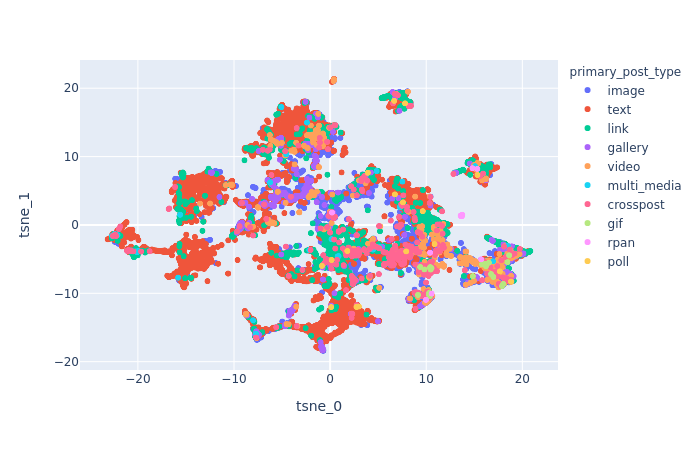

In [411]:
import plotly.express as px

for c_ in l_cols_to_fill:
    fig = px.scatter(
        df_emb_svd2_meta,
        x='tsne_0',
        y='tsne_1',
        color=c_,
    )

    # fig.show(renderer='png')
    
fig.show(renderer='png')

# Test running model on a df sample - can we still recover list order?

if we sample, the index will note be sequential. Will that create weird things when we join the data?

In [352]:
df_v_sub_sample = df_v_sub.sample(n=5000)
df_v_sub_sample.shape

(5000, 514)

In [353]:
df_v_sub_sample.head()

,subreddit_name,subreddit_id,embeddings_0,embeddings_1,embeddings_2,embeddings_3,embeddings_4,embeddings_5,embeddings_6,embeddings_7,embeddings_8,embeddings_9,embeddings_10,embeddings_11,embeddings_12,embeddings_13,embeddings_14,embeddings_15,embeddings_16,embeddings_17,embeddings_18,embeddings_19,embeddings_20,embeddings_21,embeddings_22,embeddings_23,embeddings_24,embeddings_25,embeddings_26,embeddings_27,...,embeddings_482,embeddings_483,embeddings_484,embeddings_485,embeddings_486,embeddings_487,embeddings_488,embeddings_489,embeddings_490,embeddings_491,embeddings_492,embeddings_493,embeddings_494,embeddings_495,embeddings_496,embeddings_497,embeddings_498,embeddings_499,embeddings_500,embeddings_501,embeddings_502,embeddings_503,embeddings_504,embeddings_505,embeddings_506,embeddings_507,embeddings_508,embeddings_509,embeddings_510,embeddings_511
18416,watchexchange,t5_2sqne,-0.021939,0.005883,-0.010466,-0.011518,-0.033790,0.051289,-0.046604,-0.015209,-0.053451,0.021518,0.008787,-0.014581,-0.015821,-0.002434,0.044683,0.026866,0.034348,0.011175,-0.005854,0.023919,-0.021054,-0.019021,-0.006804,0.019183,0.009778,-0.017738,-0.007719,0.029651,...,0.014161,0.000819,0.020313,-0.010048,-0.014551,-0.033403,-0.003284,0.021792,-0.035260,0.028984,0.024430,0.008338,-0.022686,0.003059,-0.006597,0.016329,0.044487,0.030730,0.032004,0.022936,-0.029630,-0.013982,-0.018744,0.021835,0.033481,-0.008096,-0.030290,-0.001516,0.020930,0.018488
4354,danielandgian,t5_q9p9v,0.026782,0.005526,0.011002,0.036724,0.016487,0.023460,0.009990,-0.006078,-0.032716,-0.007463,-0.019719,-0.008546,-0.049284,0.010793,0.003126,0.016388,-0.011245,-0.019299,0.040535,-0.025812,-0.005235,-0.028683,0.017631,0.001781,-0.003217,-0.004873,0.020827,-0.011820,...,-0.021730,-0.011758,0.014550,-0.025935,0.027893,-0.025124,-0.018383,0.021610,0.009779,0.006321,-0.000724,0.006849,0.014965,0.002668,0.011394,0.003517,-0.008948,0.010858,-0.004891,0.021499,-0.029411,-0.005439,0.008602,0.025013,0.023989,-0.011092,0.008819,-0.008599,-0.008446,0.007888
10762,meetnewpeoplehere,t5_3kpir,0.023329,0.017003,-0.007470,0.010085,-0.057287,0.033161,0.013759,0.013507,-0.052886,0.020586,0.001832,-0.007105,0.037224,0.006689,-0.017870,-0.012968,0.019401,0.003751,0.050420,-0.026679,-0.006466,-0.014141,0.050283,-0.005814,-0.028398,-0.022326,0.034662,0.003529,...,0.023019,-0.011926,-0.010717,0.036910,-0.004760,-0.054093,0.025556,-0.035160,0.020743,-0.006252,-0.006885,0.012369,0.052973,-0.019737,-0.029211,-0.016477,-0.009199,-0.046007,-0.002388,0.010598,-0.009289,-0.026665,-0.005924,-0.018007,0.005666,-0.005717,0.022103,-0.048283,0.029015,0.061162
2369,bocajuniors,t5_2ve4t,-0.007313,0.004699,-0.015537,0.007344,0.023756,0.041434,0.005902,0.011395,-0.034386,0.000361,0.014834,-0.016905,-0.003051,0.000532,0.010360,0.003261,0.015371,0.004627,0.001338,0.019604,0.004396,-0.022838,-0.004231,0.003868,-0.005398,-0.000432,-0.002898,-0.003210,...,0.025826,-0.022908,0.011786,-0.027270,0.005641,-0.049783,0.008971,0.020797,0.010436,-0.028328,0.015070,-0.006509,-0.000584,-0.018787,0.015431,0.017303,-0.002889,0.022255,-0.021832,-0.005855,-0.023435,0.010361,-0.019419,0.007356,-0.001532,0.003911,-0.005601,-0.017812,0.018504,0.028055
9616,latamhistorymemes,t5_4xdv2r,-0.009735,-0.020529,0.003443,0.015253,0.015752,0.039340,0.020373,-0.027105,-0.008881,0.005596,0.028069,-0.023335,-0.031876,0.004442,-0.022999,-0.025862,0.025026,-0.031021,0.000685,-0.003191,0.006043,-0.006620,-0.009540,0.002072,-0.018412,-0.017280,0.002398,0.013122,...,0.019132,-0.033534,0.010504,-0.026516,-0.000440,-0.026383,-0.002513,-0.009892,0.011017,-0.031092,0.016597,0.020200,-0.010742,-0.014988,0.023993,0.019516,-0.009734,0.019167,-0.026676,0.031529,-0.024993,0.037138,-0.006726,0.029991,-0.008763,-0.012691,0.018081,0.032028,0.006301,0.015775


## Run model & get linkage + leaves

In [354]:
%%time

cls_agg_ward_euc_coF = AgglomerativeClustering(
    n_clusters=65,
    compute_distances=True,
    compute_full_tree=True,
    affinity='euclidean',
    linkage='ward',
    connectivity=None,
)

cls_agg_ward_euc_coF.fit(df_v_sub_sample[l_cols_embeddings])
print(len(set(cls_agg_ward_euc_coF.labels_)))


65
CPU times: user 5.03 s, sys: 49.5 ms, total: 5.08 s
Wall time: 5.08 s


In [355]:
# df_v_sub_sample[l_cols_embeddings].to_numpy()

In [356]:
%%time
X_linkage_euc_coF = clustering_utils.create_linkage_for_dendrogram(cls_agg_ward_euc_coF)


CPU times: user 12.9 ms, sys: 1.15 ms, total: 14.1 ms
Wall time: 13.7 ms


In [357]:
leaves_list(X_linkage_euc_coF).shape

(5000,)

In [358]:
pd.Series(leaves_list(X_linkage_euc_coF)).describe()

count    5000.000000
mean     2499.500000
std      1443.520003
min         0.000000
25%      1249.750000
50%      2499.500000
75%      3749.250000
max      4999.000000
dtype: float64

### Old method
This one assumed that the index was ordered so we joined on an regular index.

This is wrong - we can see there are a lot of items that are null when we join this way.

In [359]:
df_leaves_order_old = pd.DataFrame(
    {'index': leaves_list(X_linkage_euc_coF)},
)
df_leaves_order_old.index.name = 'model_leaves_list_order_left_to_right'
df_leaves_order_old = (
    df_leaves_order_old
    .reset_index()
    .set_index('index')
    .assign(cluster_label=fcluster(X_linkage_euc_coF, 65, criterion='maxclust'))
)
# df_leaves_order_old

In [360]:
df_leaves_order_old.merge(
    df_v_sub_sample.iloc[:, :10],
    how='right',
    left_index=True,
    right_index=True,
).sort_values(by='model_leaves_list_order_left_to_right', ascending=True).head(20)

,model_leaves_list_order_left_to_right,cluster_label,subreddit_name,subreddit_id,embeddings_0,embeddings_1,embeddings_2,embeddings_3,embeddings_4,embeddings_5,embeddings_6,embeddings_7
990,5.0,23.0,apexoutlands,t5_w4q80,-0.011491,-0.016416,-0.002442,0.007699,-0.006714,0.044035,0.016438,0.001195
3114,6.0,62.0,ceh,t5_2s32x,-0.019457,0.019829,0.014742,-0.004484,-0.045025,0.005393,-0.006047,-0.015467
3824,7.0,28.0,cordoba,t5_2rpmh,-0.025469,0.006835,0.006064,0.014761,-0.042045,0.018806,0.015434,0.012539
1552,9.0,43.0,avb,t5_2vt73,-0.025124,-0.008787,-0.014916,-0.012011,-0.044465,0.051717,-0.008126,-0.023787
2599,13.0,28.0,brexit,t5_33mm8,-0.024971,-0.014328,0.005152,-0.002482,0.039962,0.044657,0.035458,-0.014377
1077,15.0,52.0,archlinux,t5_2qrzu,-0.037451,-0.009604,0.008582,0.016456,-0.041499,-0.069545,0.018166,-0.009144
1897,17.0,18.0,beamprivacy,t5_m7f5d,-0.022542,-0.010017,-0.047406,-0.048193,-0.017150,0.011192,-0.010483,0.003189
4543,18.0,47.0,deadpool,t5_2r2nx,-0.007892,-0.033756,-0.020798,0.004889,0.005312,0.047329,0.036640,-0.023403
3984,19.0,34.0,craftopia_,t5_2rv884,-0.015982,0.003037,0.016916,0.011963,-0.039021,0.031847,0.008877,-0.007560
3857,20.0,47.0,coronavirusga,t5_2gub4v,-0.003981,0.024936,-0.010681,-0.014253,0.029223,0.018513,-0.002213,-0.003771


In [339]:
leaves_list(X_linkage_euc_coF)

array([ 617, 2559, 2396, ..., 2824, 1875, 4428], dtype=int32)

### New method

reset the index of df_labels! that way we assure that both dfs will have the same index in the same order.

In [369]:
df_labels = (
    df_v_sub_sample[l_ix_sub]
    .merge(
        df_subs[l_ix_sub + ['primary_topic']],
        how='left',
        on=l_ix_sub,
    )
    .copy()
    .assign(cluster_label=fcluster(X_linkage_euc_coF, 65, criterion='maxclust'))
    .reset_index(drop=True) # must reset index for leaves order to be accurate
)
df_labels.shape

(5000, 4)

In [370]:
df_labels.head()

,subreddit_name,subreddit_id,primary_topic,cluster_label
0,watchexchange,t5_2sqne,Marketplace and Deals,4
1,danielandgian,t5_q9p9v,None,29
2,meetnewpeoplehere,t5_3kpir,None,13
3,bocajuniors,t5_2ve4t,Sports,56
4,latamhistorymemes,t5_4xdv2r,History,59


In [374]:
# assumes that df_labels has had its index reset (.reset_index())
df_leaves_order_fix = pd.DataFrame(
    {
        'model_leaves_list_order_left_to_right': range(len(df_v_sub_sample))
    },
    index=leaves_list(X_linkage_euc_coF),
)


df_leaves_order_fix.head()

,model_leaves_list_order_left_to_right
100,0
89,1
2913,2
757,3
2726,4


In [372]:
df_leaves_order_fix.merge(
    df_labels,
    how='right',
    left_index=True,
    right_index=True,
).sort_values(by='model_leaves_list_order_left_to_right', ascending=True).head(20)

,model_leaves_list_order_left_to_right,subreddit_name,subreddit_id,primary_topic,cluster_label
100,0,pythonespanol,t5_2nqgu2,None,1
89,1,pythontips,t5_3evbu,Programming,1
2913,2,python,t5_2qh0y,Programming,1
757,3,devsarg,t5_2yucqq,Technology,1
2726,4,programacion,t5_2rivb,Programming,1
990,5,leetcode,t5_3mlga,Programming,1
3114,6,softwaredevelopment,t5_2qhqc,Technology,1
3824,7,askcomputerscience,t5_2shke,Learning and Education,1
934,8,javahelp,t5_2t1jq,Programming,1
1552,9,cpp_questions,t5_2tdbd,Programming,1


In [373]:
df_leaves_order_fix.merge(
    df_labels,
    how='right',
    left_index=True,
    right_index=True,
).sort_values(by='model_leaves_list_order_left_to_right', ascending=True).tail(20)

,model_leaves_list_order_left_to_right,subreddit_name,subreddit_id,primary_topic,cluster_label
3671,4980,jerkoff2desicelebs,t5_12vdk1,Mature Themes and Adult Content,65
3853,4981,mrunal_thakur,t5_4wk6kt,None,65
441,4982,mouniroy,t5_27ix2c,None,65
3907,4983,afazenda13,t5_51ko6k,None,65
2350,4984,desitvbabes,t5_2gxg0p,None,65
3918,4985,desivideos,t5_2saax,None,65
1589,4986,indianactressphotos,t5_4xalxs,None,65
2426,4987,dirtybollywoodgossip,t5_2louqd,None,65
2489,4988,southcelebgossip,t5_2e8vnr,None,65
1827,4989,bollywoodonyoutube,t5_2wzne,None,65


In [302]:
df_leaves_order

,index,model_leaves_list_order_left_to_right
0,60,14794
1,160,6978
2,158,751
3,899,2348
4,205,18499
...,...,...
995,107,16222
996,994,15680
997,617,17492
998,148,12437


In [300]:
df_v_sub_sample[l_cols_embeddings].index.to_series().describe()

count     1000.000000
mean      9518.586000
std       5658.471181
min          2.000000
25%       4646.250000
50%       9376.500000
75%      14576.000000
max      19141.000000
dtype: float64

In [ ]:
LEGACY

# Evaluate clusters
- [Calinski-Harabasz](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.calinski_harabasz_score.html#sklearn.metrics.calinski_harabasz_score)
- [Silhoutte](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html#sklearn.metrics.silhouette_score)
    - [Demo with images](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py)

Test how long it takes to evaluate scores on 500 subs to get a sense of magnitude.

In [ ]:
TODO

In [84]:
n_sample = 10500

X_test = df_v_sub.iloc[:n_sample, :]

X_svd = df_subs_meta_and_svd.iloc[:n_sample].copy()
X_tsne = df_emb_svd2_meta.iloc[:n_sample].copy()
X_tsne['labels_test_agg35'] = agg_cluster_ward_cosine_35.labels_[:n_sample]
X_tsne['labels_test_agg35_no_conn'] = agg_cluster_ward_cosine_35_connf.labels_[:n_sample]

AttributeError: 'AgglomerativeClustering' object has no attribute 'labels_'

### Silhouette

#### Agg

In [193]:
%%time

silhouette_avg_agg = silhouette_score(X_test[l_cols_embeddings], X_tsne['labels_test_agg'])

CPU times: user 12.3 s, sys: 19.8 s, total: 32.1 s
Wall time: 2.33 s


In [192]:
%%time

silhouette_avg_agg_cos = silhouette_score(X_test[l_cols_embeddings], X_tsne['labels_test_agg'], metric='cosine')

CPU times: user 12 s, sys: 19.1 s, total: 31.1 s
Wall time: 1.96 s


In [101]:
%%timeit

silhouette_avg_agg = silhouette_score(X_test[l_cols_embeddings], labels_test_agg)

2.35 s ± 36.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### K-means

In [99]:
%%time

silhouette_avg_km = silhouette_score(X_test[l_cols_embeddings], X_tsne['labels_test_kmeans'])

CPU times: user 11.9 s, sys: 18.7 s, total: 30.6 s
Wall time: 2.26 s


In [194]:
%%time

silhouette_avg_km_cos = silhouette_score(X_test[l_cols_embeddings], X_tsne['labels_test_kmeans'], metric='cosine')

CPU times: user 12.4 s, sys: 20.7 s, total: 33.1 s
Wall time: 1.94 s


In [102]:
%%timeit

silhouette_avg_km = silhouette_score(X_test[l_cols_embeddings], labels_test_kmeans)

2.33 s ± 84.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [126]:
print(f"{silhouette_avg_agg:,.4f} Agg")
print(f"{silhouette_avg_agg_cos:,.4f} Agg cosine")
print(f"{silhouette_avg_km:,.4f} Kmeans")
print(f"{silhouette_avg_km_cos:,.4f} Kmeans cosine")

0.0466 Agg
0.0977 Agg cosine
0.0720 Kmeans
0.1303 Kmeans cosine


In [122]:
# agg_cluster_ward_25.cluster_centers_

In [80]:
y_lower = 10
n_clusters = len(set(X_tsne['labels_test_agg']))
cluster_labels = X_tsne['labels_test_agg']
sample_silh = X_tsne['silhouette_sample_agg']
try:
    # Labeling the clusters
    centers = agg_cluster_ward_25.cluster_centers_
except AttributeError:
    pass


fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)

for i in sorted(set(cluster_labels)):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silh[cluster_labels == i]

    ith_cluster_silhouette_values.to_numpy().sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

# 2nd Plot showing the actual clusters formed
colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
ax2.scatter(X_svd.loc[:, 'svd_0'], X_svd.loc[:, 'svd_1'], marker='.', s=30, lw=0, alpha=0.7,
            c=colors, edgecolor='k')

# add TSNE
fig = px.scatter(
    X_tsne,
    x='tsne_0',
    y='tsne_1',
    color=cluster_labels,
)
fig.show(renderer='png')

# try:
#     # Draw white circles at cluster centers
#     ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
#                 c="white", alpha=1, s=200, edgecolor='k')

#     for i, c in enumerate(centers):
#         ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
#                     s=50, edgecolor='k')
# except (NameError, AttributeError):
#     pass

KeyError: 'labels_test_agg'

In [201]:
%%time

# Compute the silhouette scores for each sample
X_tsne['silhouette_sample_km'] = silhouette_samples(X_test[l_cols_embeddings], X_tsne['labels_test_kmeans'])

CPU times: user 12.2 s, sys: 18.8 s, total: 31 s
Wall time: 2.45 s


In [202]:
%%time

# Compute the silhouette scores for each sample
X_tsne['silhouette_sample_km_cos'] = silhouette_samples(X_test[l_cols_embeddings], X_tsne['labels_test_kmeans'], metric='cosine')

CPU times: user 11.7 s, sys: 21.4 s, total: 33.1 s
Wall time: 1.93 s


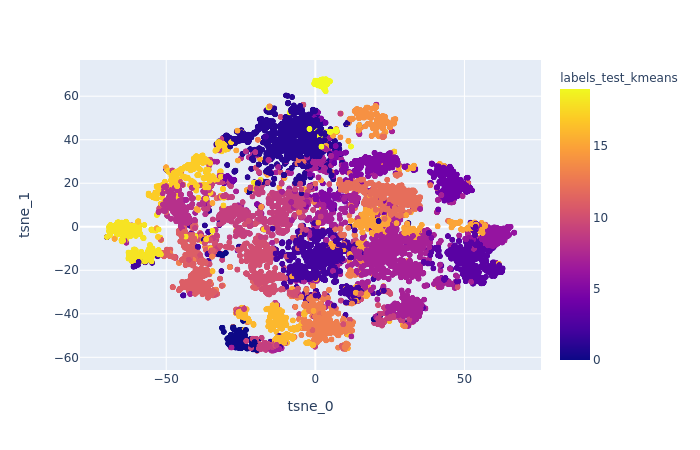

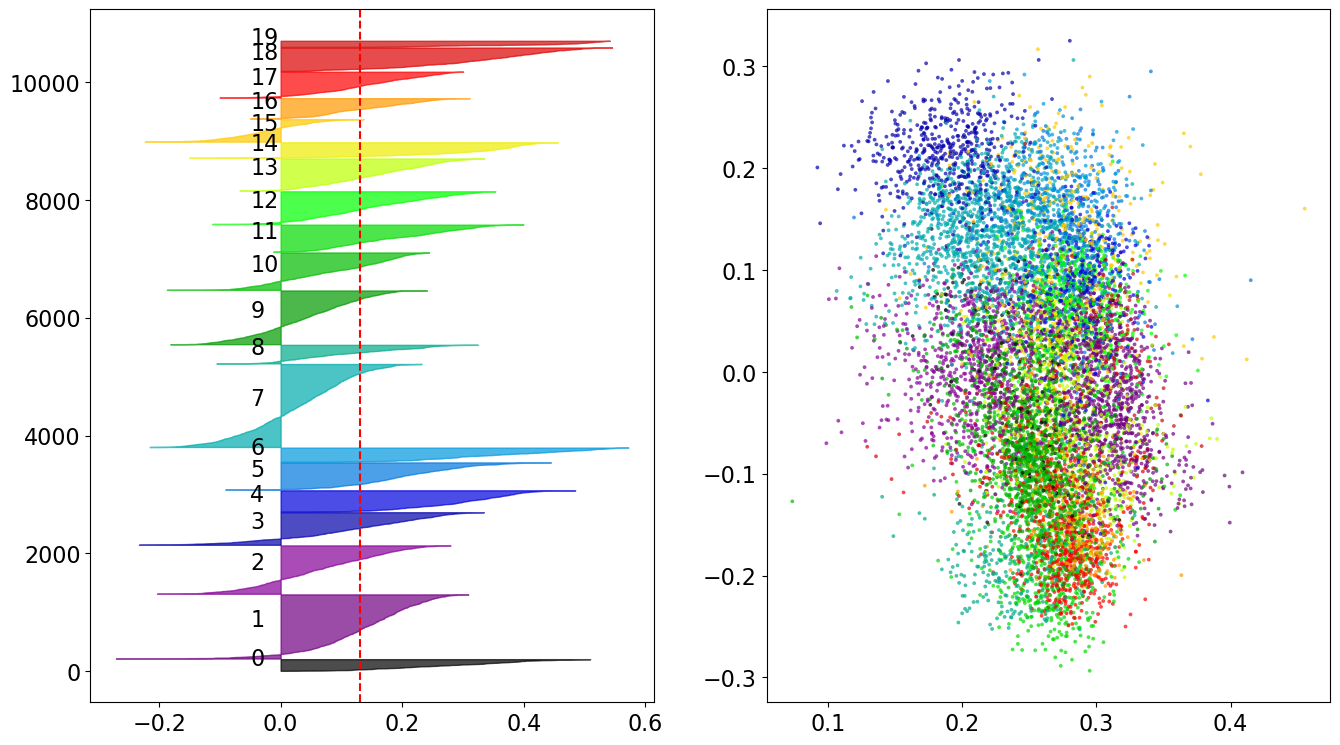

In [205]:
y_lower = 10
n_clusters = len(set(X_tsne['labels_test_kmeans']))
cluster_labels = X_tsne['labels_test_kmeans'] 
sample_silh = X_tsne['silhouette_sample_km_cos'] 
silh_avg = silhouette_avg_km_cos
try:
    # Labeling the clusters
    centers = kmeans_20.cluster_centers_
except AttributeError:
    pass


fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(16, 9)

for i in sorted(set(cluster_labels)):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silh[cluster_labels == i]

    ith_cluster_silhouette_values.to_numpy().sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

# 2nd Plot showing the actual clusters formed
colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
ax2.scatter(X_svd.loc[:, 'svd_0'], X_svd.loc[:, 'svd_1'], marker='.', s=30, lw=0, alpha=0.7,
            c=colors, edgecolor='k')

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silh_avg, color="red", linestyle="--")

# add TSNE
fig = px.scatter(
    X_tsne,
    x='tsne_0',
    y='tsne_1',
    color=cluster_labels,
)
fig.show(renderer='png')

# try:
#     # Draw white circles at cluster centers
#     ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
#                 c="white", alpha=1, s=200, edgecolor='k')

#     for i, c in enumerate(centers):
#         ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
#                     s=50, edgecolor='k')
# except (NameError, AttributeError):
#     pass

### Distribution of scores
plot distribution of individual silhouette scores instead of the example from sklearn b/c gettig a distribution will be more meaningful

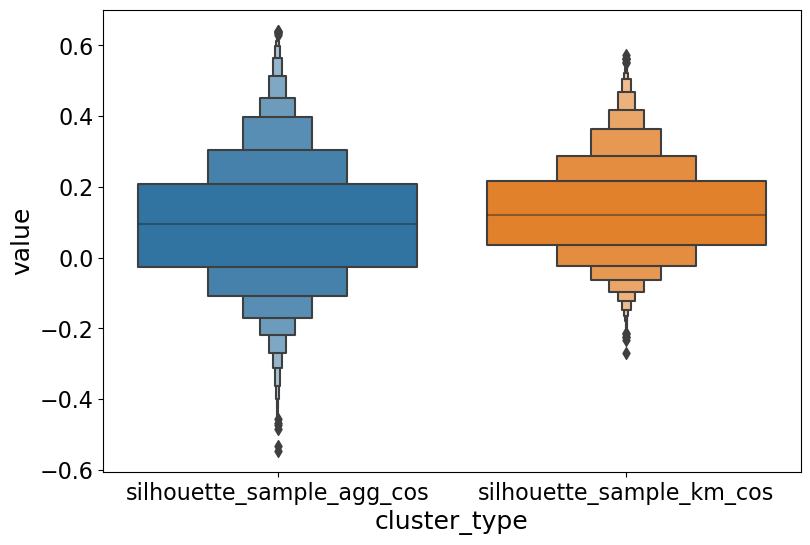

In [228]:
# we'll need to concat the dfs to show the plots on the same axis
df_plot = (
    X_tsne[['silhouette_sample_agg_cos', 'silhouette_sample_km_cos']]
    .stack().reset_index()
    .rename(columns={'level_0': 'index',
                     'level_1': 'cluster_type',
                     0: 'value'
                     })
)


ax = sns.boxenplot(data=df_plot, 
                   x="cluster_type",
                   y='value',
                  )
# ax = sns.boxenplot(data=X_tsne, x="silhouette_sample_km_cos",
#                    # orient="v",
#                    label='silhouette_sample_km_cos'
#                    )
# plt.legend()

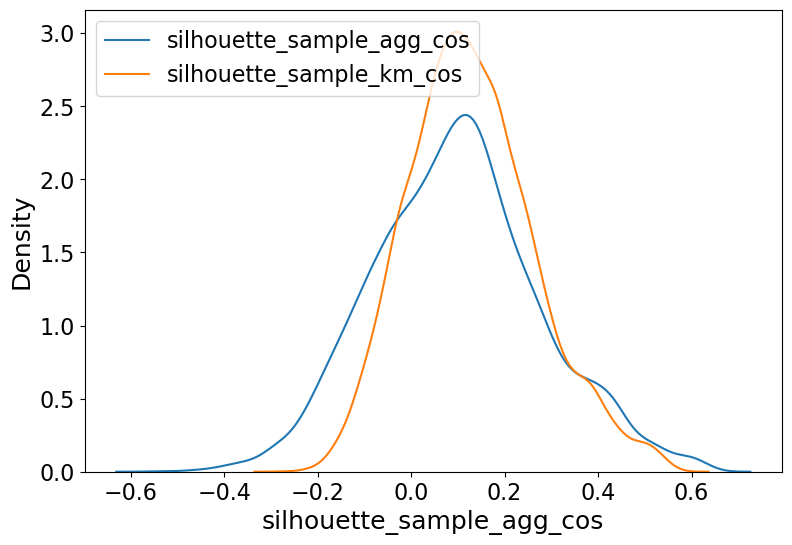

In [229]:
ax = sns.kdeplot(X_tsne["silhouette_sample_agg_cos"],
                   # orient="v",
                   label='silhouette_sample_agg_cos',
                   )
ax = sns.kdeplot(X_tsne["silhouette_sample_km_cos"],
                   # orient="v",
                   label='silhouette_sample_km_cos'
                   )
plt.legend()

### Plot by the median of each group

This can make it easier to see how many groups are above/below mean

In [231]:
df_clust_agg_desc = (
    X_tsne.groupby('labels_test_agg')['silhouette_sample_agg_cos']
    .describe()
    .sort_values(by=['50%'], ascending=False)
)

df_clust_agg_desc.index

,count,mean,std,min,25%,50%,75%,max
labels_test_agg,,,,,,,,
23,73.0,0.547773,0.102497,-0.040738,0.526595,0.576830,0.603601,0.641179
17,156.0,0.458536,0.120525,0.083342,0.363787,0.478004,0.560783,0.635146
20,207.0,0.398670,0.135489,-0.126448,0.342481,0.434811,0.502671,0.551399
12,301.0,0.356981,0.092324,0.049818,0.303714,0.373253,0.425758,0.527521
19,258.0,0.306540,0.123689,-0.180821,0.251007,0.357826,0.392837,0.454196
15,366.0,0.319047,0.123568,-0.180586,0.255004,0.344176,0.410567,0.539545
24,162.0,0.322400,0.105873,0.015767,0.274855,0.341686,0.407237,0.476670
14,436.0,0.211424,0.113504,-0.210278,0.145968,0.213926,0.289730,0.455720
18,447.0,0.152394,0.131570,-0.298166,0.083757,0.182256,0.258229,0.340805


CPU times: user 440 ms, sys: 106 ms, total: 546 ms
Wall time: 469 ms


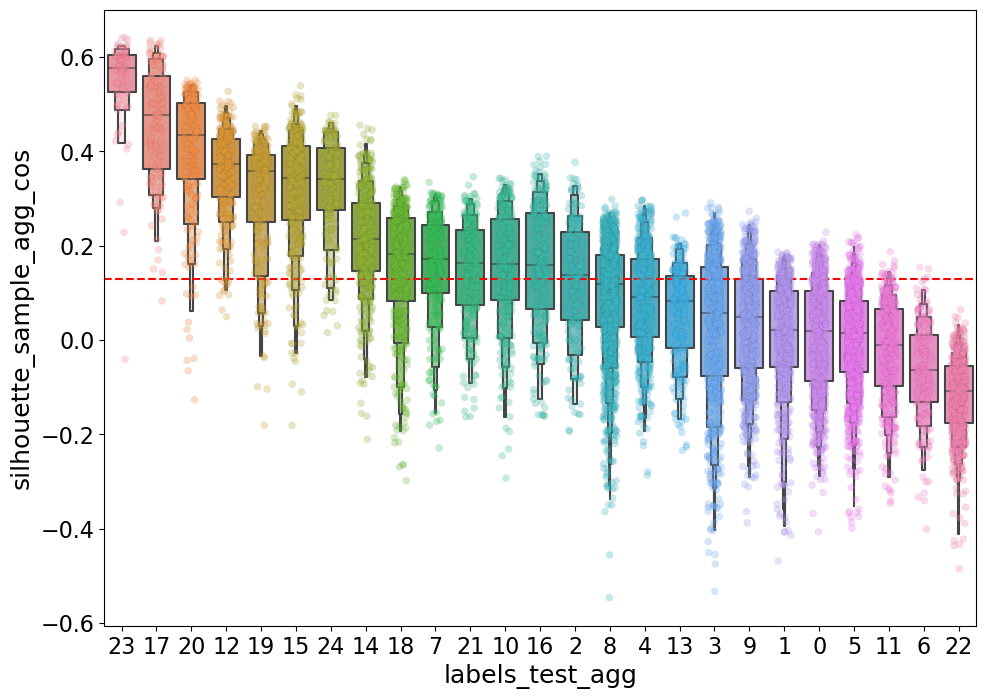

In [257]:
%%time
n_clusters = X_tsne['labels_test_agg'].nunique()

fig = plt.figure(figsize=(.45 * n_clusters, 8))

ax = sns.stripplot(
    data=X_tsne, y="silhouette_sample_agg_cos", x='labels_test_agg', 
    jitter=0.2, alpha=0.3, edgecolor='#191919', linewidth=0.1,
    order=df_clust_agg_desc.index,
)

ax = sns.boxenplot(
    data=X_tsne, y="silhouette_sample_agg_cos", x='labels_test_agg',
    orient="v", showfliers=False,
    order=df_clust_agg_desc.index,
)


# The vertical line for average silhouette score of all the values
ax.axhline(y=silh_avg, color="red", linestyle="--")

In [175]:
X_tsne.shape

(10500, 93)

In [176]:
X_svd.shape

(10500, 141)

In [174]:
X_svd

array([-0.02087881,  0.3087285 ,  0.12999455, ...,  0.07575442,
        0.0071102 ,  0.2475552 ])

### CH score

#### Agg

In [137]:
%%time

ch_avg_agg = calinski_harabasz_score(X_test[l_cols_embeddings], labels_test_agg)

CPU times: user 114 ms, sys: 1.2 ms, total: 116 ms
Wall time: 114 ms


In [139]:
%%timeit

calinski_harabasz_score(X_test[l_cols_embeddings], labels_test_agg)

86 ms ± 5.82 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### K-means

In [140]:
%%time

ch_avg_km = calinski_harabasz_score(X_test[l_cols_embeddings], labels_test_kmeans)

CPU times: user 93.6 ms, sys: 2.22 ms, total: 95.8 ms
Wall time: 94.1 ms


In [141]:
%%timeit

calinski_harabasz_score(X_test[l_cols_embeddings], labels_test_kmeans)

86.5 ms ± 5.49 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [142]:
print(f"{ch_avg_agg:,.4f} Agg")
print(f"{ch_avg_km:,.4f} Kmeans")

170.9684 Agg
227.0373 Kmeans


# Merge svd + metadata + cluster info to visualize the clusters

In [377]:
# df_vect_svd.head()

### Merge all (posts & subs)

In [590]:
d_cluster_name_and_labels_all = {
    'cluster_id_kmeans20_all': kmeans_20_all.labels_,
}

df_all_meta_plot = df_v_all[l_ix_post].copy()

# Add cluster IDs for different methods
for c_name, labels_ in d_cluster_name_and_labels_all.items():
    df_all_meta_plot[c_name] = labels_
    df_all_meta_plot[c_name] = df_all_meta_plot[c_name].astype(str)

    
df_all_meta_plot = pd.concat(
    [
        df_all_meta_plot[df_all_meta_plot['post_id'].isnull()]
        .merge(
            (
                # keep only the SUBREDDIT coordinates
                df_vect_svd[df_vect_svd.index.get_level_values('post_id').isnull()]
                .reset_index()
                [['svd_0', 'svd_1', 'svd_2'] + l_ix_sub]
            ),
            how='left',
            on=l_ix_sub,
        ),
        df_all_meta_plot[~df_all_meta_plot['post_id'].isnull()]
        .merge(
            (
                # keep only the POST-LEVEL coordinates
                df_vect_svd[~df_vect_svd.index.get_level_values('post_id').isnull()]
                .reset_index()
                [['svd_0', 'svd_1', 'svd_2'] + l_ix_post]
            ),
            how='left',
            on=l_ix_post,
        )
    ],
    axis=0,
    ignore_index=False,
).merge(
    # Merge sub-level metadata
    df_subs,
    how='left',
    on=l_ix_sub,
)

df_all_meta_plot.shape

(262854, 48)

In [596]:
# df_all_meta_plot.head()

In [597]:
# df_all_meta_plot.tail()

#### Save for checking later

In [598]:

shape_ = df_all_meta_plot.shape
(
    df_all_meta_plot
    #.astype({'post_nsfw': str})
    .to_parquet(
        path_this_model / f'df_posts_and_subs-k_means_clustering-{shape_[0]}_by_{shape_[1]}.parquet'
    )
)

### Merge for subreddit-only

In [644]:
d_cluster_name_and_labels = {
    'cluster_id_agg_ward_25': agg_cluster_ward_25.labels_,
    'cluster_id_agg_ward_35': agg_cluster_ward_35.labels_,
    'cluster_id_agg_ward_cosine_35': agg_cluster_ward_cosine_35.labels_,
    
    'cluster_id_agg_avg_cosine_35': agg_cluster_avg_cosine_35.labels_,
    'cluster_id_agg_complete_cosine_35': agg_cluster_complete_cosine_35.labels_,
    
    'cluster_id_kmeans8': kmeans_8.labels_,
    'cluster_id_kmeans15': kmeans_15.labels_,
    'cluster_id_kmeans20': kmeans_20.labels_,
    
    'cluster_id_hdbscan_cosine': cluster_cosine.labels_,
    'cluster_id_hdbscan_euclidean': cluster.labels_,
    'cluster_id_hdbscan_cosine': cluster_cosine.labels_,
    'cluster_id_hdbscan_cosine_soft': np.argmax(soft_clusters_cosine, axis=1)
}

In [645]:
df_subs_meta_plot = df_v_sub[l_ix_sub].copy()

# Add cluster IDs for different methods
for c_name, labels_ in d_cluster_name_and_labels.items():
    df_subs_meta_plot[c_name] = labels_
    df_subs_meta_plot[c_name] = df_subs_meta_plot[c_name].astype(str)

df_subs_meta_plot = (
    df_subs_meta_plot
    .merge(
        (
            # keep only the subreddit coordinates
            df_vect_svd[df_vect_svd.index.get_level_values('post_id').isnull()]
            .reset_index()
            [['svd_0', 'svd_1', 'svd_2'] + l_ix_sub]
        ),
        how='left',
        on=l_ix_sub,
    )
    .merge(
        df_subs,
        how='left',
        on=l_ix_sub,
    )
)

# append the label using all data:
df_subs_meta_plot = (
    df_all_meta_plot[df_all_meta_plot['post_id'].isnull()]
    [l_ix_sub + [k for k in d_cluster_name_and_labels_all.keys()]]
#     .drop(['post_id', 'svd_0', 'svd_1', 'svd_2'], axis=1)
    .merge(
        df_subs_meta_plot,
        how='right',
        on=l_ix_sub
    )
)

df_subs_meta_plot.shape

(628, 58)

#### Save for checking later

In [647]:
# df_subs_meta_plot.head()

In [648]:

shape_ = df_subs_meta_plot.shape
(
    df_subs_meta_plot
    .to_parquet(
        path_this_model / f'df_subs_only-multiple_clustering_algos-{shape_[0]}_by_{shape_[1]}.parquet'
    )
)

In [614]:
# counts_describe(df_subs_meta_plot)

In [638]:
# df_subs_meta_plot.head()

# Start plotting

In [616]:
df_posts['submit_date'] = pd.to_datetime(df_posts['submit_date'], format="%Y-%m-%d")

In [69]:
df_posts['submit_date'].describe()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.



count                  262226
unique                     75
top       2021-05-17 00:00:00
freq                     4658
first     2021-04-01 00:00:00
last      2021-06-14 00:00:00
Name: submit_date, dtype: object

In [617]:
# meta for all posts
n_posts = len(df_v_posts)  # len(df_emb_svd2)
n_subs = df_posts['subreddit_name'].nunique()
first_date = df_posts['submit_date'].min()
last_date = df_posts['submit_date'].max()


## Custom hover over data
use sparingly! adding too much overlay data can make makes the images too large for the notebook to save.

**Be careful with this template**

In [618]:

posts_hover_data = "<br>".join([
    "subreddit name: %{customdata[0]}",
    "subreddit manual label: %{customdata[1]}",
#    "post text: %{customdata[2]}",
#    "  %{customdata[3]}"
])

l_custom_data_posts = ['subreddit_name', col_manual_labels,
                       # 'text_1',
                       # 'text_2'
                      ]

### set default colors for categories

In [619]:
# sns.palplot([v for v in get_color_dict('dirl').values()])

In [620]:
# sns.palplot([v for v in get_color_dict('plotly').values()])

15  Total keys in d_new
15  Unique values in d_new
Unused keys from d_ref:
  []
15  Total keys in d_new
15  Unique values in d_new
Unused keys from d_ref:
  ['blue_purple', 'orange', 'mint', 'orange_light', 'yellow']


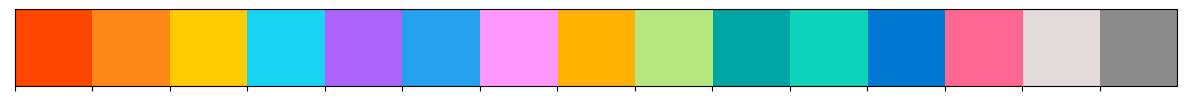

In [621]:
d_manual_label_colors = base_colors_for_manual_labels()
sns.palplot([v for v in d_manual_label_colors.values()])
check_colors_used(d_manual_label_colors, get_color_dict('dirl'))
check_colors_used(d_manual_label_colors, get_color_dict('plotly'))

## Plot by cluster ID

In [622]:
# df_subs_meta_plot.head()

## Subreddit-level

In [484]:
# %%time

# df_plot_ = df_subs_meta_plot

# for c_name in d_cluster_name_and_labels.keys():   
#     fig = px.scatter(
#         df_plot_,
#         y='svd_0', x='svd_1',
#         color=c_name,
#     )

#     fig.update_layout(
#         title_text=(
#             f"{len(df_plot_):,.0f} Posts from __ German-relevant subreddits"
#             f"<br>Clustering algo: {c_name.replace('cluster_id', '').replace('_', ' ')}"
#             # f"<br>Using posts from 04-01-2021 to 05-08-2021"
#         ),
#         title_x=0.5,
#         width=900,
#         height=700,
#     #     uniformtext_minsize=8, uniformtext_mode='hide'
#     )

#     # fig.show()
#     fig.show(renderer='png')
#     display(value_counts_and_pcts(df_plot_[c_name], top_n=10))

# Show subreddit names for each cluster

In [650]:
cols_to_front = [
    'subreddit_name',
    
    'manual_topic_and_rating',
    
    'subreddit_title',
    'post_median_word_count',
    'subreddit_name_title_and_clean_descriptions_word_count',
    
]
cols_to_exclude = [
    'subreddit_public_description',
    'subreddit_description',

    'subreddit_name_title_and_clean_descriptions',
    
]

In [651]:
# df_subs_meta_plot.head()

In [485]:
# col_clustering = 'cluster_id_agg_ward_cosine_35'

# for id_ in sorted(df_subs_meta_plot[col_clustering].unique()):
#     mask_ = df_subs_meta_plot[col_clustering] == id_
#     print(f"\nCluster ID: {id_}\n  {mask_.sum()} Subreddit count in group")
    
#     cols_to_display = reorder_array(
#         cols_to_front,
#         df_subs_meta_plot.drop(cols_to_exclude, axis=1).columns
#     )
#     display(value_counts_and_pcts(df_subs_meta_plot[mask_][col_manual_labels]))
#     display(
#         style_df_numeric(
#             df_subs_meta_plot[mask_][cols_to_display]
#             .sort_values(by=['users_l28'], ascending=False)
#             .head(10)
#             ,
#             rename_cols_for_display=True,
#         )
#     )

In [654]:
# col_clustering = 'cluster_id_hdbscan_cosine_soft'

# for id_ in sorted(df_subs_meta_plot[col_clustering].unique()):
#     mask_ = df_subs_meta_plot[col_clustering] == id_
#     print(f"\nCluster ID: {id_}\n  {mask_.sum()} Subreddit count in group")
    
#     cols_to_display = reorder_array(
#         cols_to_front,
#         df_subs_meta_plot.drop(cols_to_exclude, axis=1).columns
#     )
#     display(value_counts_and_pcts(df_subs_meta_plot[mask_][col_manual_labels]))
#     display(
#         style_df_numeric(
#             df_subs_meta_plot[mask_][cols_to_display]
#             .sort_values(by=['users_l28'], ascending=False)
#             .head(10)
#             ,
#             rename_cols_for_display=False,
#         )
#     )

## Post-level

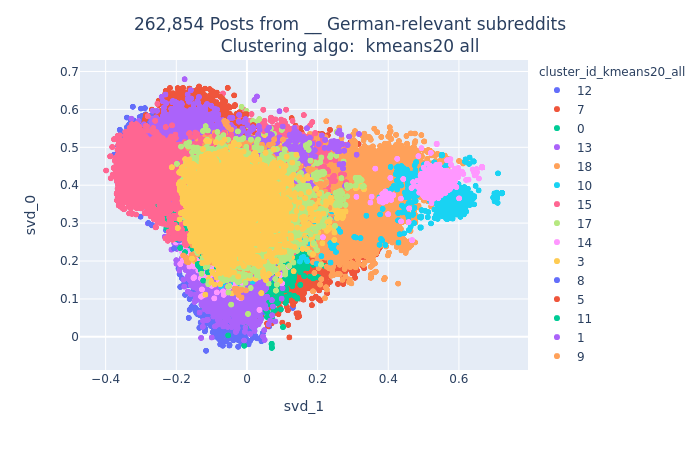

,cluster_id_kmeans20_all-count,cluster_id_kmeans20_all-percent,cluster_id_kmeans20_all-pct_cumulative_sum
13,"29,350",11.2%,11.2%
0,"28,215",10.7%,21.9%
7,"23,958",9.1%,31.0%
12,"23,506",8.9%,40.0%
15,"21,761",8.3%,48.2%
17,"16,761",6.4%,54.6%
5,"14,681",5.6%,60.2%
16,"11,171",4.2%,64.4%
18,"10,612",4.0%,68.5%
2,"10,509",4.0%,72.5%


CPU times: user 2.31 s, sys: 50.2 ms, total: 2.36 s
Wall time: 4.89 s


In [587]:
%%time

df_plot_ = df_all_meta_plot

for c_name in d_cluster_name_and_labels_all.keys():   
    fig = px.scatter(
        df_plot_,
        y='svd_0', x='svd_1',
        color=c_name,
    )

    fig.update_layout(
        title_text=(
            f"{len(df_plot_):,.0f} Posts from __ German-relevant subreddits"
            f"<br>Clustering algo: {c_name.replace('cluster_id', '').replace('_', ' ')}"
            # f"<br>Using posts from 04-01-2021 to 05-08-2021"
        ),
        title_x=0.5,
        width=900,
        height=700,
    #     uniformtext_minsize=8, uniformtext_mode='hide'
    )

    # fig.show()
    fig.show(renderer='png')
    display(value_counts_and_pcts(df_plot_[c_name], top_n=10))

### Subreddit groups, based on k-means on posts AND subs

If we clustering at the post-level, could we get meaningful clusters at the subreddit-level?

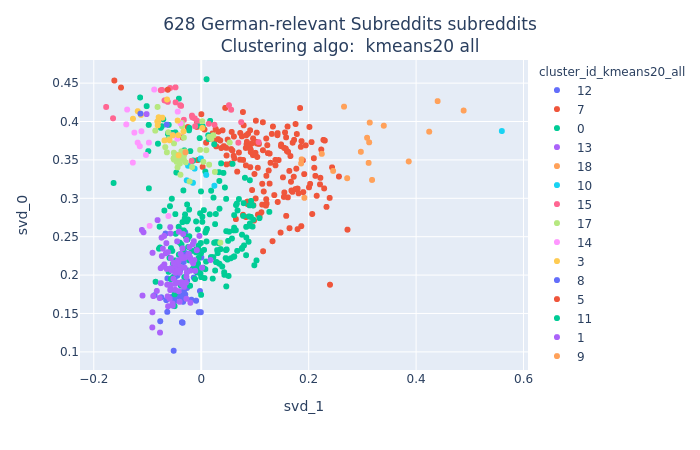

,cluster_id_kmeans20_all-count,cluster_id_kmeans20_all-percent,cluster_id_kmeans20_all-pct_cumulative_sum
0,192,30.6%,30.6%
7,162,25.8%,56.4%
13,94,15.0%,71.3%
12,45,7.2%,78.5%
17,41,6.5%,85.0%
15,23,3.7%,88.7%
18,18,2.9%,91.6%
3,17,2.7%,94.3%
14,16,2.5%,96.8%
10,7,1.1%,97.9%


CPU times: user 134 ms, sys: 7.32 ms, total: 141 ms
Wall time: 376 ms


In [601]:
%%time

df_plot_ = df_all_meta_plot[df_all_meta_plot['post_id'].isnull()]

for c_name in d_cluster_name_and_labels_all.keys():   
    fig = px.scatter(
        df_plot_,
        y='svd_0', x='svd_1',
        color=c_name,
    )

    fig.update_layout(
        title_text=(
            f"{len(df_plot_):,.0f} German-relevant Subreddits subreddits"
            f"<br>Clustering algo: {c_name.replace('cluster_id', '').replace('_', ' ')}"
            # f"<br>Using posts from 04-01-2021 to 05-08-2021"
        ),
        title_x=0.5,
        width=900,
        height=700,
    #     uniformtext_minsize=8, uniformtext_mode='hide'
    )

    # fig.show()
    fig.show(renderer='png')
    display(value_counts_and_pcts(df_plot_[c_name], top_n=10))

In [551]:
cols_to_front = [
    'subreddit_name',
    
    'manual_topic_and_rating',
    
    'subreddit_title',
    'subreddit_public_description',
    'post_median_word_count',
    'subreddit_name_title_and_clean_descriptions_word_count',
    
]
cols_to_exclude = [
    'subreddit_description',
    'subreddit_name_title_and_clean_descriptions',
    
]

In [603]:
# df_all_meta_plot.head()

In [623]:
# col_clustering = 'cluster_id_kmeans20_all'
# df_plot_ = df_all_meta_plot[df_all_meta_plot['post_id'].isnull()]

# for id_ in sorted(df_plot_[col_clustering].unique()):
#     mask_ = df_plot_[col_clustering] == id_
#     print(f"\nCluster ID: {id_}\n  {mask_.sum()} Subreddit count in group")
    
#     cols_to_display = reorder_array(
#         cols_to_front,
#         df_plot_.drop(cols_to_exclude, axis=1).columns
#     )
#     display(value_counts_and_pcts(df_plot_[mask_][col_manual_labels]))
#     display(
#         style_df_numeric(
#             df_plot_[mask_][cols_to_display]
#             .sort_values(by=['users_l28'], ascending=False)
#             .head(5)
#             ,
#             rename_cols_for_display=True,
#         )
#     )

In [35]:
# %%time

# cluster_posts = hdbscan.HDBSCAN()

# cluster_posts.fit(df_v_posts[l_cols_embeddings])

In [37]:
# set(cluster_posts.labels_)

# Upload model results to GCS

Primary file to use to create tables:

`df_subs_only-multiple_clustering_algos-628_by_58.parquet`
- This has the column for the best-looking cluster algo so far: `cluster_id_agg_ward_cosine_35`
- Also contains 1st 3 SVD dimensions

`df_subs_meta_and_svd-628_by_93.parquet`
- All meta AND all 50 SVD dimensions

`df_posts_meta_and_svd-262226_by_72.parquet`
- All post meta AND 50 SVD dimensions (no cluster labels)

---
Nevermind:
Split into post-level df and subreddit-level files...?
- `df_svd_posts_and_subs-262854_by_50.parquet`
<br> This file has SVD matrix for all posts AND subreddits...
Would it make sense to create a new column to flag which things are posts & which are comments?


In [ ]:
BREAK

In [70]:
# this manual path is for the run that had the best results.
path_manual_model = Path(
    '/home/jupyter/subreddit_clustering_i18n/data/models/clustering/manual_2021-07-20_15_13'
)
path_manual_model

PosixPath('/home/jupyter/subreddit_clustering_i18n/data/models/clustering/manual_2021-07-20_15_13')

### Check files to upload

In [71]:
[f.name for f in path_manual_model.glob('*') if f.is_file()]

['df_subs_only-multiple_clustering_algos-628_by_54.parquet',
 'df_subs_only-multiple_clustering_algos-628_by_53.parquet',
 'df_subs_meta_and_svd-628_by_93.parquet',
 'df_svd_posts_and_subs-262854_by_50.parquet',
 'df_posts_and_subs-k_means_clustering-262854_by_48.parquet',
 'df_posts_meta_and_svd-262226_by_72.parquet',
 'df_subs_only-multiple_clustering_algos-628_by_58.parquet',
 'df_subs_only-multiple_clustering_algos-628_by_95.parquet']

In [72]:
# for f in [f for f in path_manual_model.glob('*') if f.is_file()]:
#     print(f.name)
#     if f.name == 'df_svd_posts_and_subs-262854_by_50.parquet':
#         df_svd_all = pd.read_parquet(f)
# #         df_vect_svd = pd.read_parquet(f)
#     else:
#         pass

In [73]:
for f in [f for f in path_manual_model.glob('*') if f.is_file()]:
    print(f.name)
    
    df_ = pd.read_parquet(f)
    display(df_.iloc[:5, :10])
#     display(df_.head())

df_subs_only-multiple_clustering_algos-628_by_54.parquet


,subreddit_name,subreddit_id,cluster_id_kmeans20_all,cluster_id_agg_cluster_ward_25,cluster_id_kmeans8,cluster_id_kmeans15,cluster_id_kmeans20,cluster_id_hdbscan_cosine,cluster_id_hdbscan_euclidean,cluster_id_hdbscan_cosine_soft
0,1fcnuernberg,t5_30jst,12,2,5,5,0,0,4,0
1,3thedward,t5_2eeymn,7,19,6,2,18,-1,3,12
2,600euro,t5_3caax,0,23,2,13,18,-1,3,12
3,aachen,t5_2t4y2,13,12,1,0,2,5,3,8
4,aeiou,t5_2qmr6,0,19,6,2,18,11,3,11


df_subs_only-multiple_clustering_algos-628_by_53.parquet


,subreddit_name,subreddit_id,cluster_id_kmeans20_all,cluster_id_kmeans8,cluster_id_kmeans15,cluster_id_kmeans20,cluster_id_hdbscan_cosine,cluster_id_hdbscan_euclidean,cluster_id_hdbscan_cosine_soft,svd_0
0,1fcnuernberg,t5_30jst,12,5,5,0,0,4,0,0.222840
1,3thedward,t5_2eeymn,7,6,2,18,-1,3,12,0.255387
2,600euro,t5_3caax,0,2,13,18,-1,3,12,0.233825
3,aachen,t5_2t4y2,13,1,0,2,5,3,8,0.219124
4,aeiou,t5_2qmr6,0,6,2,18,11,3,11,0.276386


df_subs_meta_and_svd-628_by_93.parquet


,subreddit_id,subreddit_name,geo_country_code,pct_sv_country,rank_no,subreddit_info_ambassador,subreddit_topic_ambassador,combined_topic,combined_topic_and_rating,rating
0,t5_30jst,1fcnuernberg,DE,0.851266,659.0,None,None,uncategorized,uncategorized,None
1,t5_2eeymn,3thedward,DE,0.909091,984.0,None,None,uncategorized,uncategorized,None
2,t5_3caax,600euro,DE,0.926953,15.0,None,None,internet culture and memes,internet culture and memes,r
3,t5_2t4y2,aachen,DE,0.839318,210.0,None,None,uncategorized,uncategorized,pg
4,t5_2qmr6,aeiou,AT,0.856129,5.0,None,None,internet culture and memes,internet culture and memes,pg


df_svd_posts_and_subs-262854_by_50.parquet


,,,svd_0,svd_1,svd_2,svd_3,svd_4,svd_5,svd_6,svd_7,svd_8,svd_9
subreddit_name,subreddit_id,post_id,,,,,,,,,,
1fcnuernberg,t5_30jst,NaN,0.222840,0.000204,0.024081,0.063317,-0.132110,-0.055637,0.040146,-0.046460,-0.052776,-0.008773
3thedward,t5_2eeymn,NaN,0.255387,0.147757,0.032305,-0.061291,-0.118992,-0.000174,-0.009139,-0.058684,0.043216,0.009949
600euro,t5_3caax,NaN,0.233825,0.036164,-0.006401,0.014257,-0.148316,0.001211,0.042717,0.000280,-0.027061,0.000389
aachen,t5_2t4y2,NaN,0.219124,-0.043050,-0.050471,0.158570,-0.120792,-0.057563,-0.022799,0.029657,0.046299,0.026831
aeiou,t5_2qmr6,NaN,0.276386,0.088939,0.015256,-0.029987,-0.155789,0.010343,0.001697,-0.013627,-0.002120,0.028648


df_posts_and_subs-k_means_clustering-262854_by_48.parquet


,subreddit_name,subreddit_id,post_id,cluster_id_kmeans20_all,svd_0,svd_1,svd_2,geo_country_code,pct_sv_country,rank_no
0,1fcnuernberg,t5_30jst,None,12,0.222840,0.000204,0.024081,DE,0.851266,659.0
1,3thedward,t5_2eeymn,None,7,0.255387,0.147757,0.032305,DE,0.909091,984.0
2,600euro,t5_3caax,None,0,0.233825,0.036164,-0.006401,DE,0.926953,15.0
3,aachen,t5_2t4y2,None,13,0.219124,-0.043050,-0.050471,DE,0.839318,210.0
4,aeiou,t5_2qmr6,None,0,0.276386,0.088939,0.015256,AT,0.856129,5.0


df_posts_meta_and_svd-262226_by_72.parquet


,subreddit_name,subreddit_id,post_id,submit_date,upvotes,combined_topic_and_rating,post_type,post_nsfw,geolocation_country_code,post_url
0,1fcnuernberg,t5_30jst,t3_mjwbjc,2021-04-04,18,uncategorized,text,False,de,/r/1FCNuernberg/comments/mjwbjc/1_fc_nürnberg_sc_paderborn_07_21_11/
1,1fcnuernberg,t5_30jst,t3_mjwik7,2021-04-04,47,uncategorized,image,False,de,https://i.redd.it/ng48176vu5r61.png
2,1fcnuernberg,t5_30jst,t3_mm8azo,2021-04-07,28,uncategorized,image,False,de,https://i.redd.it/0xr02x7ulsr61.jpg
3,1fcnuernberg,t5_30jst,t3_moqu14,2021-04-11,9,uncategorized,text,False,de,/r/1FCNuernberg/comments/moqu14/fc_würzburger_kickers_1_fc_nürnberg_11_01/
4,1fcnuernberg,t5_30jst,t3_mpibr7,2021-04-12,4,uncategorized,link,False,de,https://www.fcn.de/index.php?id=19217&tx_ttnews%5Btt_news%5D=33136&cHash=0602ee17c1f5efadbed49bf5150514c8


df_subs_only-multiple_clustering_algos-628_by_58.parquet


,subreddit_name,subreddit_id,cluster_id_kmeans20_all,cluster_id_agg_ward_25,cluster_id_agg_ward_35,cluster_id_agg_ward_cosine_35,cluster_id_agg_avg_cosine_35,cluster_id_agg_complete_cosine_35,cluster_id_kmeans8,cluster_id_kmeans15
0,1fcnuernberg,t5_30jst,12,2,26,18,11,25,5,5
1,3thedward,t5_2eeymn,7,19,19,32,1,11,6,2
2,600euro,t5_3caax,0,23,11,10,1,4,2,13
3,aachen,t5_2t4y2,13,12,25,6,0,22,1,0
4,aeiou,t5_2qmr6,0,19,19,32,1,11,6,2


df_subs_only-multiple_clustering_algos-628_by_95.parquet


,subreddit_name,subreddit_id,cluster_id_kmeans20_all,geo_country_code_x,pct_sv_country_x,rank_no_x,subreddit_info_ambassador_x,subreddit_topic_ambassador_x,combined_topic_x,combined_topic_and_rating_x
0,1fcnuernberg,t5_30jst,12,DE,0.851266,659.0,None,None,uncategorized,uncategorized
1,3thedward,t5_2eeymn,7,DE,0.909091,984.0,None,None,uncategorized,uncategorized
2,600euro,t5_3caax,0,DE,0.926953,15.0,None,None,internet culture and memes,internet culture and memes
3,aachen,t5_2t4y2,13,DE,0.839318,210.0,None,None,uncategorized,uncategorized
4,aeiou,t5_2qmr6,0,AT,0.856129,5.0,None,None,internet culture and memes,internet culture and memes


### Upload files

In [75]:
path_this_model_prev_run

PosixPath('/home/jupyter/subreddit_clustering_i18n/data/models/clustering/manual_2021-07-20_15_13')

In [76]:
bucket_upload_dir = f'gs://i18n-subreddit-clustering/data/models/clustering/{path_this_model_prev_run.name}'
bucket_upload_dir

'gs://i18n-subreddit-clustering/data/models/clustering/manual_2021-07-20_15_13'

In [77]:
!echo $path_this_model_prev_run $bucket_upload_dir

/home/jupyter/subreddit_clustering_i18n/data/models/clustering/manual_2021-07-20_15_13 gs://i18n-subreddit-clustering/data/models/clustering/manual_2021-07-20_15_13


In [78]:
!gsutil -m cp -r $path_this_model_prev_run $bucket_upload_dir

Copying file:///home/jupyter/subreddit_clustering_i18n/data/models/clustering/manual_2021-07-20_15_13/df_subs_only-multiple_clustering_algos-628_by_54.parquet [Content-Type=application/octet-stream]...
Copying file:///home/jupyter/subreddit_clustering_i18n/data/models/clustering/manual_2021-07-20_15_13/df_subs_only-multiple_clustering_algos-628_by_53.parquet [Content-Type=application/octet-stream]...
Copying file:///home/jupyter/subreddit_clustering_i18n/data/models/clustering/manual_2021-07-20_15_13/df_subs_meta_and_svd-628_by_93.parquet [Content-Type=application/octet-stream]...
Copying file:///home/jupyter/subreddit_clustering_i18n/data/models/clustering/manual_2021-07-20_15_13/df_svd_posts_and_subs-262854_by_50.parquet [Content-Type=application/octet-stream]...
Copying file:///home/jupyter/subreddit_clustering_i18n/data/models/clustering/manual_2021-07-20_15_13/df_posts_and_subs-k_means_clustering-262854_by_48.parquet [Content-Type=application/octet-stream]...
Copying file:///home/